# **Setup e carregamento do conjunto de dados**

Aqui começamos por importar as bibliotecas necessárias, carregar os dados do ficheiro CSV.


**Imports**

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy import stats
import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.pipeline import Pipeline
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, kruskal, pearsonr, spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, make_scorer


**Configuração do estilo**

In [42]:
plt.style.use('default') 
sns.set_style("whitegrid") 
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

**Carregamento do CSV**

In [43]:
DATA_PATH = Path("group_15.csv")
assert DATA_PATH.exists(), f"Ficheiro não encontrado: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)

# **Exploração inicial**
Aqui exploramos o dataset para entender melhor a sua estrutura e conteúdo e fazemos algumas conversões de tipos de dados.

---

## Visualização inicial dos dados

**Dimensão do conjunto de dados**

In [44]:
print("Dimensão:", df.shape)

Dimensão: (3000, 49)


**Amostra do conjunto de dados**

In [45]:
df.head()

duration_1  duration_2  duration_3  duration_4  duration_5  loudness_level  \
0         0.0         0.0         1.0         0.0         0.0             4.0   
1         0.0         0.0         0.0         1.0         0.0             2.0   
2         0.0         0.0         0.0         1.0         0.0             4.0   
3         0.0         0.0         0.0         1.0         0.0             4.0   
4         0.0         0.0         0.0         1.0         0.0             2.0   

   popularity_level  tempo_class  time_signature  key_mode  ...  \
0               3.0          1.0        0.221824  0.767388  ...   
1               3.0          1.0        0.221824  0.485996  ...   
2               3.0          1.0        0.221824  0.485996  ...   
3               3.0          2.0        0.221824 -0.076786  ...   
4               3.0          1.0        0.221824  0.485996  ...   

   is_instrumental  is_dance_hit  temp_zscore  resonance_factor  timbre_index  \
0              0.0           0.0     0.755223          1.619076      0.778312   
1              0.0           0.0     0.634436         -1.100584      0.086806   
2              0.0           0.0     0.635036         -1.173949      0.011324   
3              0.0           0.0    -1.528729          0.669622      0.954538   
4              0.0           0.0    -0.929196          0.863212      0.706977   

   echo_constant  distorted_movement  signal_power  target_class  \
0              1            0.093345         0.232      class_53   
1              1            0.300788         0.365      class_53   
2              1            0.352649         0.327      class_53   
3              1            1.447484         0.162      class_53   
4              1           -1.589244         0.295      class_53   

   target_regression  
0           0.930791  
1           0.751458  
2           0.213459  
3           0.572125  
4           0.572125  

[5 rows x 49 columns]

**Tipos de dados do conjunto**

In [46]:
dtypes = df.dtypes.astype(str).to_frame("dtype")
display(
    dtypes.style
        .format()
        # .bar(subset=['dtype'], color='#8B0000')  # Remover esta linha!
        .set_caption('Tipos de dados das colunas')
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#8B0000'),
                                         ('color', 'white'),
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]}
        ])
)

## Coversão de tipos de dados

**Visualização das colunas do tipo 'object'**

Verificamos que existem algumas colunas que são do tipo 'object', vamos verificar se algumas dessas colunas podem ser convertidas para numéricas.

In [47]:
display(
    df.select_dtypes(include=['object']).head(10).style
        .set_caption('Amostra de colunas do tipo object')
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#8B0000'), 
                                         ('color', 'white'), 
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]}
        ])
)

**Conversão de colunas para numéricas**

Como verificamos acima, as colunas 'signal_strength', 'focus_factor' e 'signal_power' são do tipo 'object' mas  podem ser convertidas para numéricas.
Vamos proceder a essas conversões.

In [48]:
df['signal_strength']= pd.to_numeric(df['signal_strength'], errors='coerce')
df['focus_factor']= pd.to_numeric(df['focus_factor'], errors='coerce')
df['signal_power']= pd.to_numeric(df['signal_power'], errors='coerce')

print(df[['signal_strength', 'focus_factor', 'signal_power']])

      signal_strength  focus_factor  signal_power
0               0.232      0.000548         0.232
1               0.365      0.000000         0.365
2               0.327      0.000000         0.327
3               0.162      0.023500         0.162
4               0.295      0.000279         0.295
...               ...           ...           ...
2995            0.993      0.945000         0.993
2996            0.895      0.919000         0.895
2997            0.999      0.988000         0.999
2998            0.998      0.992000         0.998
2999            0.508      0.000000         0.508

[3000 rows x 3 columns]


## Tratamento de duplicados, nulos e valores únicos

**Remoção de Duplicados**

In [49]:
# Calcular duplicados
total_linhas = len(df)
linhas_duplicadas = df.duplicated().sum()
percentagem_duplicados = (linhas_duplicadas / total_linhas) * 100

print(f"Total de linhas: {total_linhas}")
print(f"Linhas duplicadas: {linhas_duplicadas}")
print(f"Percentagem de duplicados: {percentagem_duplicados:.2f}%")

df.drop_duplicates()

Total de linhas: 3000
Linhas duplicadas: 0
Percentagem de duplicados: 0.00%


duration_1  duration_2  duration_3  duration_4  duration_5  \
0            0.0         0.0         1.0         0.0         0.0   
1            0.0         0.0         0.0         1.0         0.0   
2            0.0         0.0         0.0         1.0         0.0   
3            0.0         0.0         0.0         1.0         0.0   
4            0.0         0.0         0.0         1.0         0.0   
...          ...         ...         ...         ...         ...   
2995         0.0         0.0         0.0         1.0         0.0   
2996         0.0         0.0         0.0         1.0         0.0   
2997         0.0         0.0         0.0         1.0         0.0   
2998         0.0         0.0         0.0         1.0         0.0   
2999         0.0         0.0         0.0         1.0         0.0   

      loudness_level  popularity_level  tempo_class  time_signature  key_mode  \
0                4.0               3.0          1.0        0.221824  0.767388   
1                2.0               3.0          1.0        0.221824  0.485996   
2                4.0               3.0          1.0        0.221824  0.485996   
3                4.0               3.0          2.0        0.221824 -0.076786   
4                2.0               3.0          1.0        0.221824  0.485996   
...              ...               ...          ...             ...       ...   
2995             4.0               1.0          2.0        0.221824  1.302031   
2996             4.0               1.0          1.0        2.533318 -0.920961   
2997             4.0               1.0          2.0       -2.089669  1.330170   
2998             4.0               1.0          1.0       -2.089669  1.048779   
2999             0.0               4.0          1.0       -2.089669  1.330170   

      ...  is_instrumental  is_dance_hit  temp_zscore  resonance_factor  \
0     ...              0.0           0.0     0.755223          1.619076   
1     ...              0.0           0.0     0.634436         -1.100584   
2     ...              0.0           0.0     0.635036         -1.173949   
3     ...              0.0           0.0    -1.528729          0.669622   
4     ...              0.0           0.0    -0.929196          0.863212   
...   ...              ...           ...          ...               ...   
2995  ...              1.0           0.0    -2.430148         -0.362924   
2996  ...              1.0           0.0    -1.180711          1.402551   
2997  ...              1.0           0.0    -2.045170         -1.498364   
2998  ...              1.0           0.0    -0.492846         -0.677784   
2999  ...              0.0           0.0    -0.693492          0.057382   

      timbre_index  echo_constant  distorted_movement  signal_power  \
0         0.778312              1            0.093345         0.232   
1         0.086806              1            0.300788         0.365   
2         0.011324              1            0.352649         0.327   
3         0.954538              1            1.447484         0.162   
4         0.706977              1           -1.589244         0.295   
...            ...            ...                 ...           ...   
2995      0.498746              1           -0.384925         0.993   
2996      0.139900              1           -0.799810         0.895   
2997      0.358956              1            1.459009         0.999   
2998      0.348573              1           -1.134023         0.998   
2999      0.560500              1            0.300788         0.508   

      target_class  target_regression  
0         class_53           0.930791  
1         class_53           0.751458  
2         class_53           0.213459  
3         class_53           0.572125  
4         class_53           0.572125  
...            ...                ...  
2995     class_103          -0.055541  
2996     class_103          -0.055541  
2997     class_103          -0.055541  
2998     class_103          -0.055541  
2999     class_103    

**Análise de valores nulos e únicos**

In [50]:
num = df.select_dtypes(include='number')

info_num = (
    pd.DataFrame({
        'Variável': num.columns,
        'Tipo': num.dtypes.astype(str),
        'Faltantes': num.isna().sum(),
        '% Faltantes': (num.isna().mean() * 100).round(2),
        'Únicos': num.nunique(dropna=True)
    })
    .sort_values('Únicos', ascending=False)
    .reset_index(drop=True)
)

display(
    info_num.style
        .format({'Únicos': '{:,}'})
        .bar(subset=['Únicos'], color='#8B0000')
        .set_caption('Colunas numéricas – ordenado por cardinalidade (Únicos)')
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#8B0000'), 
                                         ('color', 'white'), 
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]}
        ])
)

total_null_values = num.isna().sum().sum()
    
null_vars = info_num[info_num['Faltantes'] > 0].sort_values('Faltantes', ascending=False)
    
print(f"Total de valores nulos no dataset: {total_null_values}")
print(f"\nVariáveis com valores nulos:")
    
if len(null_vars) > 0:
    for _, row in null_vars.iterrows():
        print(f"- {row['Variável']}: {row['Faltantes']} valores nulos ({row['% Faltantes']:.2f}%)")
    else:
        print("Nenhuma variável contém valores nulos.")

Total de valores nulos no dataset: 6

Variáveis com valores nulos:
- focus_factor: 4 valores nulos (0.13%)
- signal_strength: 1 valores nulos (0.03%)
- signal_power: 1 valores nulos (0.03%)
Nenhuma variável contém valores nulos.


**Remoção de valores nulos**

Como temos uma percentagem baixa de linhas com valores nulos, optamos por remover as linhas com valores nulos, em vez de fazer imputação.

In [51]:
df = df.dropna(how='any', axis=0)

null_count = df.isnull().any(axis=1).sum()
print(f"  - Linhas com valores nulos: {null_count}")

  - Linhas com valores nulos: 0


# **Análise exploratória dos dados**
Aqui fazemos uma análise exploratória dos dados para entender melhor as suas características e identificar possíveis padrões ou anomalias.

---

Definimos as variáveis target de classificação e regressão.

In [52]:
target_class= 'target_class'
target_regression= 'target_regression'

print("Target de classificação:", target_class)
print("Target de regressão:", target_regression)

Target de classificação: target_class
Target de regressão: target_regression


## **Estatísticas descritivas**

Este passo é importante para nos ajudar a entender melhor a distribuição dos dados e identificar possíveis outliers e tendências.

### Descrição das features numéricas
Aqui calculamos algumas estatísticas descritivas para as features numéricas do dataset.

In [53]:
desc_num = df.select_dtypes(include=[np.number]).describe().T
display(
    desc_num.style
        .format('{:.2f}')
        .bar(subset=['mean'], color='#8B0000')
        .set_caption('Resumo estatístico das features numéricas')
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#8B0000'), 
                                         ('color', 'white'), 
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]}
        ])
)

## **Análise Univariada**
-----
Esta análise foca-se em examinar cada variável individualmente para entender a sua distribuição e características.

## Target Classificação
Aqui calculamos algumas estatísticas descritivas para o target de classificação.

ANÁLISE DE BALANCEAMENTO DA VARIÁVEL ALVO


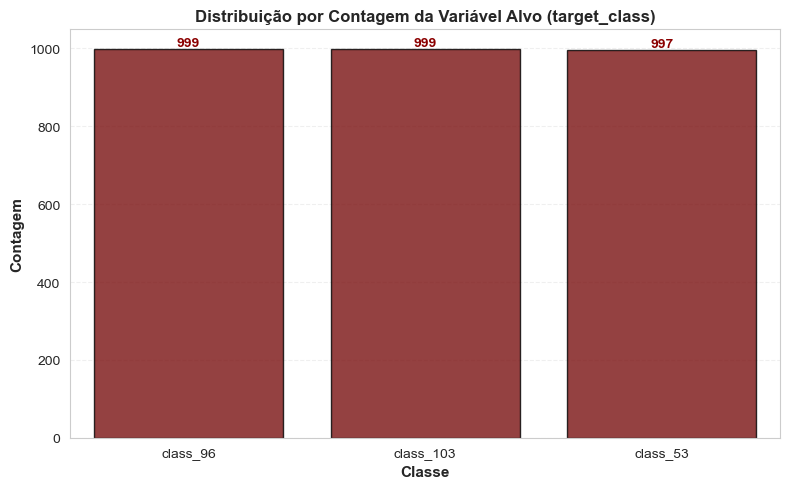

In [54]:
print('='*60)
print('ANÁLISE DE BALANCEAMENTO DA VARIÁVEL ALVO')
print('='*60)

class_dist = df[target_class].value_counts(dropna=False)
class_pct = (class_dist / class_dist.sum()) * 100

balance_info = pd.DataFrame({
    'Classe': class_dist.index,
    'Contagem': class_dist.values,
    'Percentagem (%)': class_pct.values
})

display(
    balance_info.style
        .format({'Contagem': '{:,}', 'Percentagem (%)': '{:.2f}'})
        .bar(subset=['Percentagem (%)'], color='#8B0000', vmin=0, vmax=100)
        .set_caption('Distribuição da Variável Alvo (target_class)')
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#8B0000'), 
                                         ('color', 'white'), 
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]}
        ])
)

plt.figure(figsize=(8, 5))
sns.barplot(x=class_dist.index.astype(str), y=class_dist.values, color='#8B0000', edgecolor='black', alpha=0.8)
plt.ylabel('Contagem', fontsize=11, fontweight='bold')
plt.xlabel('Classe', fontsize=11, fontweight='bold')
plt.title('Distribuição por Contagem da Variável Alvo (target_class)', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
for i, (label, value) in enumerate(zip(class_dist.index, class_dist.values)):
    plt.text(i, value, f'{value:,}', ha='center', va='bottom', fontweight='bold', color='#8B0000')
plt.tight_layout()
plt.show()

print('\n' + '='*60)

Podemos concluir que o 'target_class' está equilibrado, onde cada classe tem aproximadamente 33.3% dos registos.

## Target Regressão
Aqui calculamos algumas estatísticas descritivas para o target de regressão.

ANÁLISE DA DISTRIBUIÇÃO DA VARIÁVEL ALVO DE REGRESSÃO


c:\Users\flavi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


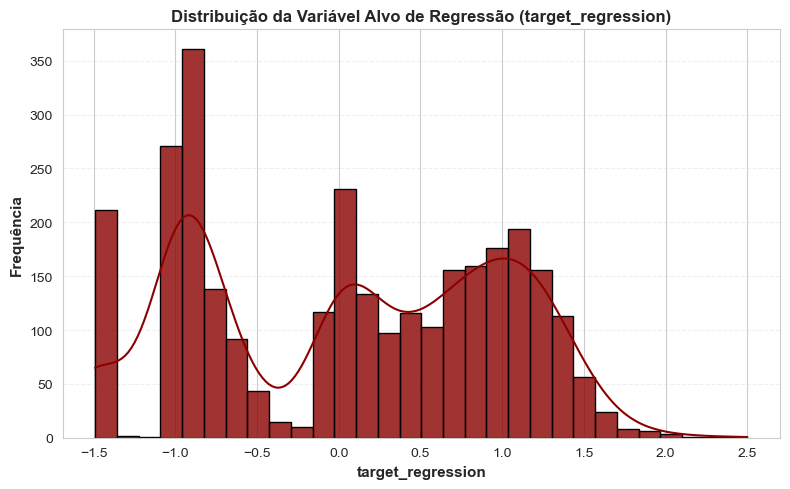

In [55]:
print('='*60)
print('ANÁLISE DA DISTRIBUIÇÃO DA VARIÁVEL ALVO DE REGRESSÃO')
print('='*60)

yreg = df[target_regression]
reg_summary = pd.Series({
    "Contagem": yreg.shape[0],
    "Média": yreg.mean(),
    "Desvio Padrão": yreg.std(ddof=1),
    "Mínimo": yreg.min(),
    "Q1 (25%)": yreg.quantile(0.25),
    "Mediana (50%)": yreg.median(),
    "Q3 (75%)": yreg.quantile(0.75),
    "Máximo": yreg.max(),
    "Skew": yreg.skew(),
    "Kurtosis": yreg.kurtosis()
}, name="Resumo target_regression")

display(
    reg_summary.to_frame().style
        .format('{:.2f}')
        .bar(subset=['Resumo target_regression'], color='#8B0000')
        .set_caption('Resumo estatístico da variável alvo de regressão')
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#8B0000'), 
                                         ('color', 'white'), 
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]}
        ])
)

plt.figure(figsize=(8, 5))
sns.histplot(yreg, bins=30, kde=True, color='#8B0000', edgecolor='black', alpha=0.8)
plt.ylabel('Frequência', fontsize=11, fontweight='bold')
plt.xlabel('target_regression', fontsize=11, fontweight='bold')
plt.title('Distribuição da Variável Alvo de Regressão (target_regression)', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print('\n' + '='*60)

##  Distribuição de todas as features 
Aqui analisamos as distribuições de todas as features do dataset pois estas features podem mostrar caracteristicas que nos ajudem no pré-processamento dos dados.

Features: 47


c:\Users\flavi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\flavi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\flavi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\flavi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

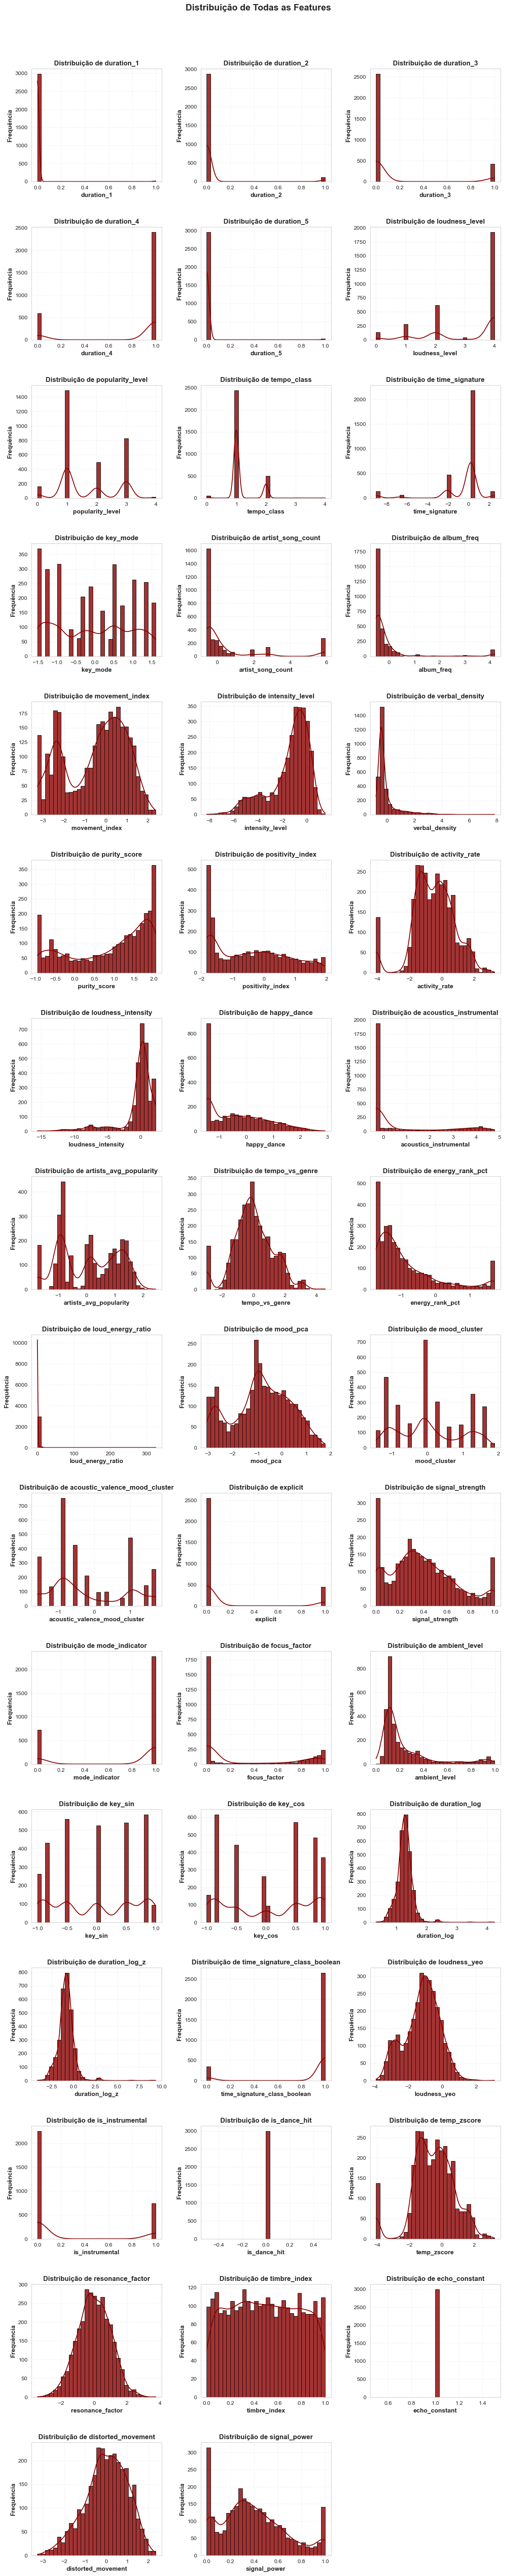

Número total de variáveis: 47


In [56]:
n_cols = 3  
features = [c for c in df.columns if c not in [target_class, target_regression]]
print(f"Features: {len(features)}")
n_rows = (len(features) + n_cols - 1) // n_cols
fig = plt.figure(figsize=(15, 5*n_rows))
gs = gridspec.GridSpec(n_rows, n_cols)
gs.update(wspace=0.3, hspace=0.4)

for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(data=df, x=feat, bins=30, kde=True, color='#8B0000', edgecolor='black', alpha=0.8)
    plt.title(f"Distribuição de {feat}", fontsize=12, fontweight='bold')
    plt.xlabel(feat, fontsize=11, fontweight='bold')
    plt.ylabel('Frequência', fontsize=11, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.3)

plt.suptitle("Distribuição de Todas as Features", y=0.90, fontsize=16, fontweight='bold')  
plt.tight_layout()
plt.show()

print(f"Número total de variáveis: {len(features)}")

## **Conclusões** da Análise Univariada
Aqui apresentamos as principais conclusões obtidas a partir da análise univariada dos dados.

### Colunas constantes
Como podemos verificar nos histogramas acima, as colunas 'is_dance_hit' e 'echo_constant' são constantes, ou seja, apresentam o mesmo valor para todos os registos. 

Estas colunas não fornecem informação útil para a modelagem e podem ser removidas do dataset.

In [57]:
const_cols = df.columns[df.nunique() <= 1].tolist()

if const_cols:
    print(f" Colunas constantes: {const_cols}")
    
df = df.drop(columns=const_cols)
display(
    df.head().style
        .set_caption('Amostra do DataFrame após remoção de colunas constantes')
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#8B0000'), 
                                         ('color', 'white'), 
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]}
        ])
)

 Colunas constantes: ['is_dance_hit', 'echo_constant']


### Diferença de escalas nos dados
Através da análise dos valores únicos e dos histogramas conseguimos identificar que algumas colunas numéricas estão em escalas diferentes. 

É importante agrupar as features pelos tipos semânticos e não apenas pelo 'dtype'. Já que diferentes tipos de variáveis numéricas podem exigir diferentes técnicas de pré-processamento.

Verificamos a existência de: 

- **Variáveis do tipo binárias** no formato de **one-hot encoding**( duration_1-5, explicit, mode_indicator, is_instrumental etc..), que são do tipo numérico mas representam categorias,


- **Variáveis categóricas discretas**(loudness_level,popularity_level, tempo_class, time signature e target_class), que são do tipo numérico mas representam categorias com uma ordem,


- **Variáveis contínuas já normalizadas (z-score)** (duration_log, temp_zscore, key_sin etc..) 


- **Variáveis contínuas não normalizadas**(album_freq, artist_song_count, signal_strength etc..).

# **Análise Bivariada**
-----
Esta análise foca-se em examinar a relação entre as features e entre as features e as variáveis target para entender o impacto de cada feature nos targets.

## Análise bivariada com o target de regressão
Aqui analisamos a relação entre as features e o target de regressão.

 Embora tenhamos dados com escalas diferentes, ainda não vamos fazer para já qualquer normalização já que os métodos de correlação que vamos usar são insensíveis a essas diferenças de escala. No entanto, utilizamos as métricas apropriadas a cada tipo de variável. 

Nesta célula são definidos manualmente os grupos de variáveis do dataset,
de acordo com a análise prévia das suas escalas e significados semânticos.

In [58]:
num_df = df.select_dtypes(include=[np.number])
X = num_df.drop(columns=[target_regression], errors='ignore')
y = df[target_regression]


# Binárias (0/1) 
binary_cols = [
    'explicit', 'mode_indicator', 'is_instrumental',
    'time_signature_class_boolean',
    'duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5',
    'key_mode'  # assumido 0/1 (ex.: minor/major)
]

# Spearman 
ordinal_cols = [
    'loudness_level', 'popularity_level', 'tempo_class', 'time_signature'
]


zscore_cols = [
    'temp_zscore', 'duration_log_z', 'key_sin', 'key_cos'
]


continuous_non_scaled = [
    'artist_song_count', 'album_freq', 'movement_index', 'intensity_level',
    'verbal_density', 'purity_score', 'positivity_index', 'activity_rate',
    'loudness_intensity', 'happy_dance', 'acoustics_instrumental',
    'artists_avg_popularity', 'tempo_vs_genre', 'energy_rank_pct',
    'loud_energy_ratio', 'mood_pca', 'mood_cluster',
    'acoustic_valence_mood_cluster', 'signal_strength', 'focus_factor',
    'ambient_level', 'duration_log', 'loudness_yeo', 'resonance_factor',
    'timbre_index', 'distorted_movement', 'signal_power'
    
]

# Para a análise bivariada e gráficos, tratamos z-scores como contínuas
continuous_cols = continuous_non_scaled + zscore_cols

**Correlação por tipo de variável**

Para ordinais usamos a **Spearman** já que esta métrica tem em conta a ordem dos valores.

Para as variáveis contínuas e binárias usamos a **Pearson**. 

In [59]:
rows = []
for c in X.columns:
    if c in ordinal_cols:
        r = df[c].corr(y, method='spearman')
        metric = 'spearman'
        vtype = 'ordinal'
    else:
        r = df[c].corr(y, method='pearson')
        metric = 'pearson'
        vtype = 'binária' if c in binary_cols else 'contínua'
    rows.append((c, r, abs(r), metric, vtype))

corr_rank_regression = (
    pd.DataFrame(rows, columns=['feature','r','|r|','metric','tipo'])
      .dropna()
      .sort_values('|r|', ascending=False)
      .set_index('feature')
)

display(
    corr_rank_regression.head(20).style
        .format({'r': '{:.2f}', '|r|': '{:.2f}'})
        .bar(subset=['|r|'], color='#8B0000')
        .set_caption('Ranking de correlações com target_regression')
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#8B0000'), 
                                         ('color', 'white'), 
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]}
        ])
)

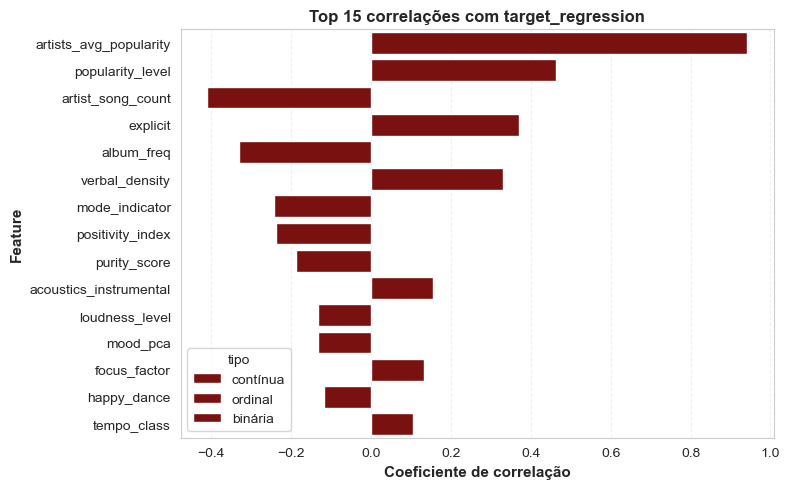

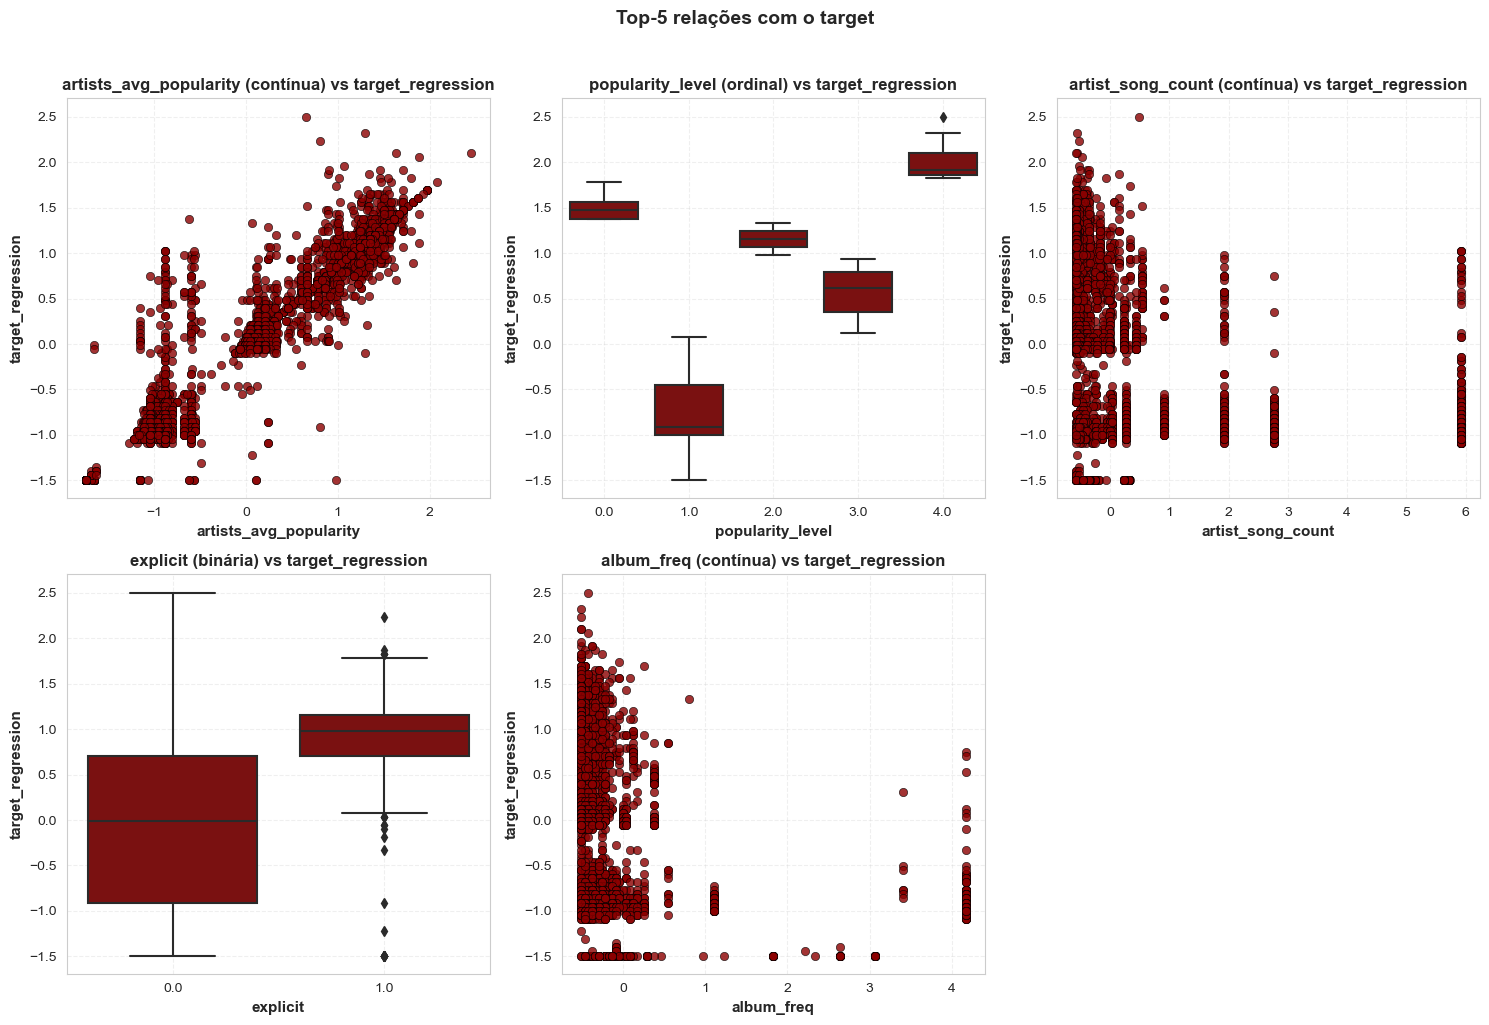

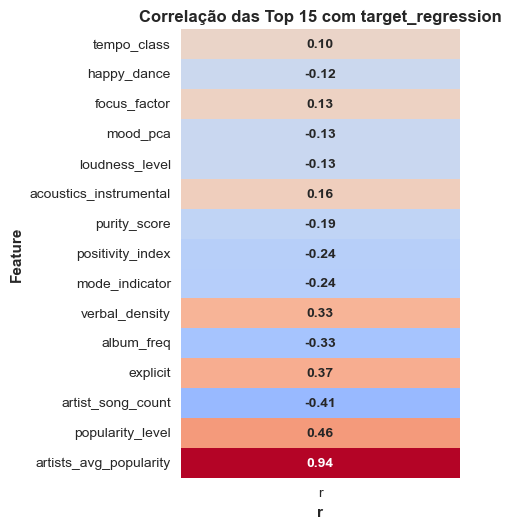

In [60]:
# Plot do ranking de correlações
TOP_N = 15
_top = corr_rank_regression.head(TOP_N).reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(data=_top, x='r', y='feature', hue='tipo', dodge=False, palette=['#8B0000','#8B0000','#8B0000'])
plt.title(f'Top {TOP_N} correlações com {target_regression}', fontsize=12, fontweight='bold')
plt.xlabel('Coeficiente de correlação', fontsize=11, fontweight='bold')
plt.ylabel('Feature', fontsize=11, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter/Box plots das top 5
top_5_features = corr_rank_regression.head(5).index.tolist()
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.delaxes(axes[1, 2])  # remove último subplot

for idx, feature in enumerate(top_5_features):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]

    if feature in continuous_cols:
        sns.scatterplot(data=df, x=feature, y=target_regression, alpha=0.8, ax=ax, color='#8B0000', edgecolor='black')
        ax.set_title(f'{feature} (contínua) vs {target_regression}', fontsize=12, fontweight='bold')
        ax.set_xlabel(feature, fontsize=11, fontweight='bold')
        ax.set_ylabel(target_regression, fontsize=11, fontweight='bold')
    else:
        sns.boxplot(data=df, x=feature, y=target_regression, ax=ax, color='#8B0000')
        ax.set_title(f'{feature} ({corr_rank_regression.loc[feature,"tipo"]}) vs {target_regression}', fontsize=12, fontweight='bold')
        ax.set_xlabel(feature, fontsize=11, fontweight='bold')
        ax.set_ylabel(target_regression, fontsize=11, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Top-5 relações com o target', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Heatmap das correlações com o target
top_feats = corr_rank_regression.head(TOP_N).index.tolist()
corr_with_target = pd.DataFrame(
    {'r': [df[c].corr(y, method='spearman' if c in ordinal_cols else 'pearson')
           for c in top_feats]},
    index=top_feats
)

plt.figure(figsize=(4.8, max(3, 0.36*len(top_feats))))
sns.heatmap(
    corr_with_target.sort_values('r', key=abs),
    annot=True, cmap='coolwarm', center=0, cbar=False, annot_kws={'fontsize':10,'fontweight':'bold'}, fmt='.2f')
plt.title(f'Correlação das Top {TOP_N} com {target_regression}', fontsize=12, fontweight='bold')
plt.xlabel('r', fontsize=11, fontweight='bold'); plt.ylabel('Feature', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

### **Conclusão** da análise bivariada com o target de regressão
A análise bivariada com o `target_regression` evidencia que variáveis como `artists_avg_popularity`, `popularity_level` e `artist_song_count` apresentam as correlações mais fortes com o alvo.  
Essas relações indicam que fatores ligados à popularidade e produtividade dos artistas têm maior impacto no valor da variável de regressão, sendo os principais preditores a considerar nos modelos de previsão.


TODO: Tirar duvida com o professor se devia fazer testes diferentes consoante a natureza da variavel

## Análise bivariada com o target de classificação
Aqui analisamos a relação entre as features e o target de classificação.

Da mesma forma que na análise bivariada com o target de regressão, utilizamos as métricas apropriadas a cada tipo de variável, sem fazer qualquer normalização prévia dos dados.

Neste caso para as variáveis **Binárias** (0/1) fazemos o teste **qui-quadrado** (associação entre duas variáveis categóricas).


Para as **ordinais**, utilizamos a **correlação de Spearman** (avalia monotonicidade entre níveis e classe).

E para as variáveis **Contínuas** (normalizadas e não normalizadas) → **ANOVA** (ou Kruskal–Wallis se não normal).

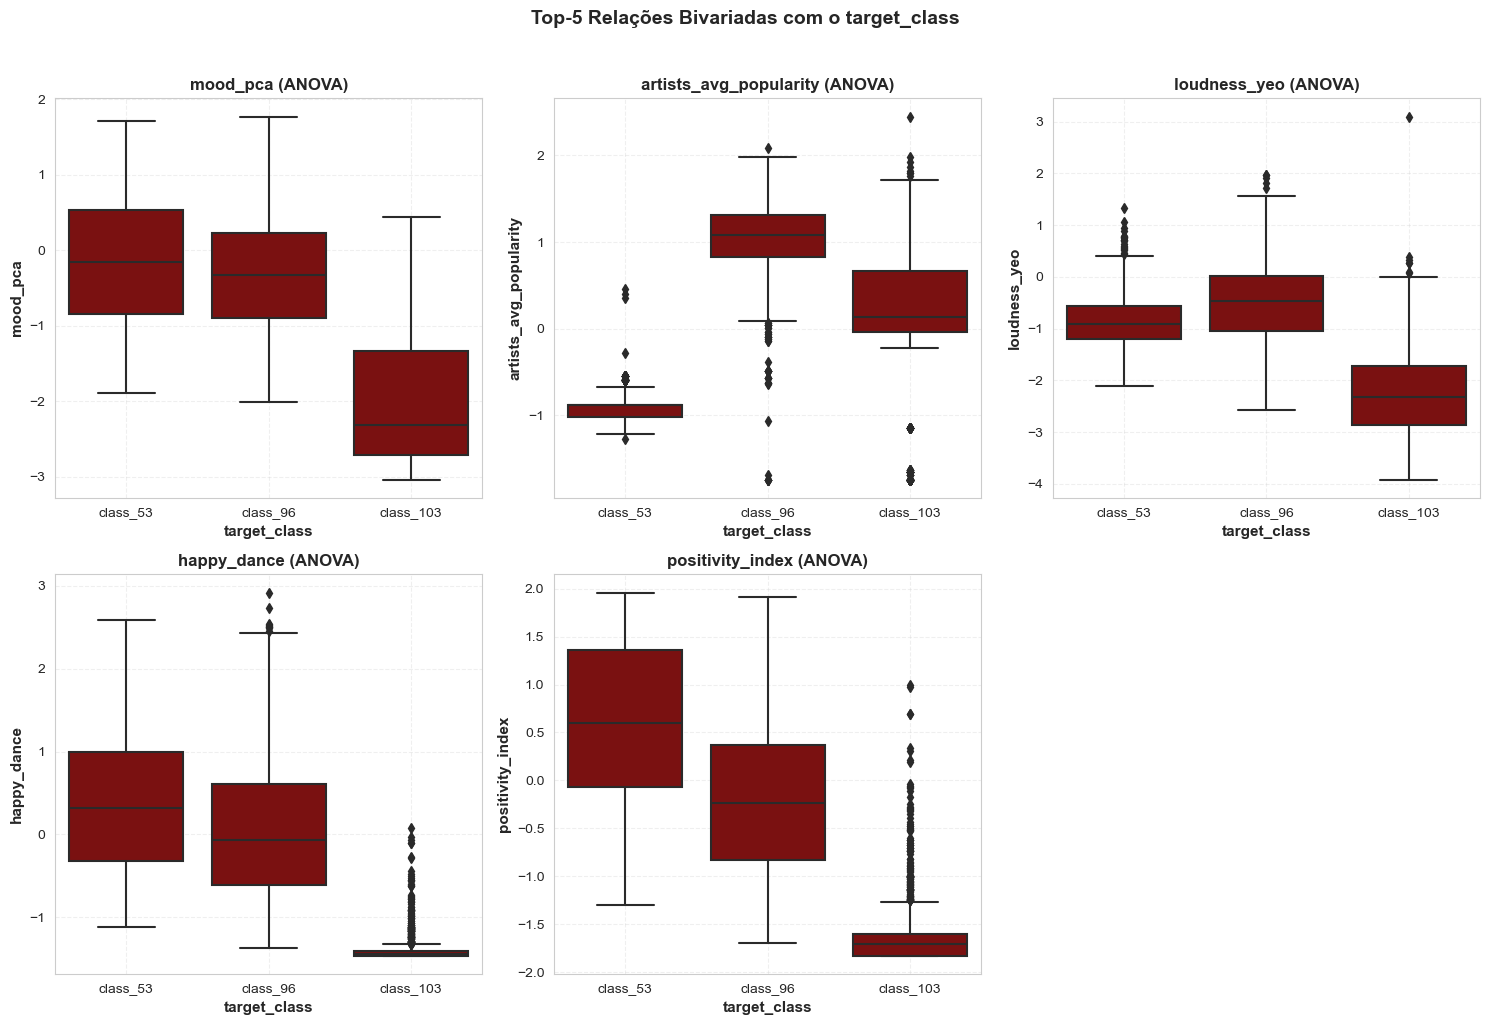

In [61]:
y_class = df['target_class']

rows = []

# --- Binárias → Qui-Quadrado
for c in binary_cols:
    tab = pd.crosstab(df[c], y_class)
    if tab.shape == (2, 2) or tab.shape[0] > 1:
        chi2, p, dof, exp = stats.chi2_contingency(tab)
        rows.append((c, 'binária', 'chi2', chi2, p))

# --- Ordinais → Spearman
for c in ordinal_cols:
    r, p = stats.spearmanr(df[c], y_class)
    rows.append((c, 'ordinal', 'spearman_r', r, p))

# --- Contínuas → ANOVA (one-way)

classes = y_class.unique()
for c in continuous_cols:
    samples = [df.loc[y_class == k, c].dropna() for k in classes]
    normal = True
    for s in samples:
        if len(s) > 3:  # Shapiro requer pelo menos 3 valores
            stat, p_shap = shapiro(s)
            if p_shap <= 0.05:
                normal = False
    if all(len(s) > 1 for s in samples):
        if normal:
            F, p = stats.f_oneway(*samples)
            rows.append((c, 'contínua', 'anova_F', F, p))
        else:
            H, p_kw = kruskal(*samples)
            rows.append((c, 'contínua', 'kruskal_H', H, p_kw))

biv_class = (
    pd.DataFrame(rows, columns=['feature', 'tipo', 'métrica', 'estatística', 'p_value'])
      .sort_values('p_value', ascending=True)
      .reset_index(drop=True)
)

display(
    biv_class.head(20).style
        .format({'estatística': '{:.2f}', 'p_value': '{:.2e}'})  # notação científica
        .bar(subset=['estatística'], color='#8B0000')
        .set_caption('Ranking de associação com target_class')
        .set_properties(**{'text-align': 'center'})
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#8B0000'),
                                         ('color', 'white'),
                                         ('font-weight', 'bold'),
                                         ('text-align', 'center')]}
        ])
)

top_feats = biv_class.head(5)['feature']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.delaxes(axes[1, 2])

for idx, feature in enumerate(top_feats):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    tipo = biv_class.loc[biv_class['feature'] == feature, 'tipo'].iloc[0]

    if tipo == 'contínua':
        sns.boxplot(data=df, x=target_class, y=feature, ax=ax, color='#8B0000')
        ax.set_title(f'{feature} (ANOVA)', fontsize=12, fontweight='bold')
        ax.set_xlabel(target_class, fontsize=11, fontweight='bold')
        ax.set_ylabel(feature, fontsize=11, fontweight='bold')

    elif tipo == 'binária':
        prop = df.groupby(target_class)[feature].mean().reset_index(name='mean')
        sns.barplot(data=prop, x=target_class, y='mean', ax=ax, color='#8B0000', edgecolor='black', alpha=0.8)
        ax.set_title(f'{feature} (% de 1 por classe)', fontsize=12, fontweight='bold')
        ax.set_xlabel(target_class, fontsize=11, fontweight='bold')
        ax.set_ylabel('Proporção', fontsize=11, fontweight='bold')

    elif tipo == 'ordinal':
        avg = df.groupby(target_class)[feature].mean().reset_index()
        sns.lineplot(data=avg, x=target_class, y=feature, marker='o', ax=ax, color='#8B0000')
        ax.set_title(f'{feature} (Spearman)', fontsize=12, fontweight='bold')
        ax.set_xlabel(target_class, fontsize=11, fontweight='bold')
        ax.set_ylabel(feature, fontsize=11, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.3)

plt.suptitle('Top-5 Relações Bivariadas com o target_class', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



### **Conclusão** da Análise Bivariada com o Target de Classificação
A análise bivariada mostra que várias variáveis contínuas (como `positivity_index`, `happy_dance` e `artists_avg_popularity`) têm forte associação com a variável-alvo (`target_class`), com valores de p muito baixos.  
Isto indica que essas features são estatisticamente relevantes para distinguir as classes e devem ser consideradas prioritárias no modelo de classificação.


## Análise bivariada entre o Target de Classificação e o Target de Regressão

Aqui analisamos a relação entre o target de classificação e o target de regressão.

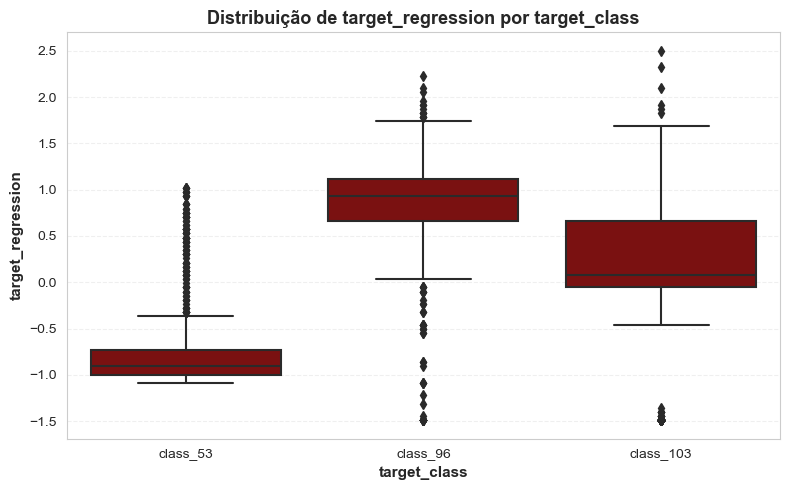

Kruskal-Wallis: H = 1419.41 | p-value = 6.02e-309


In [62]:


from scipy.stats import f_oneway, kruskal


plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='target_class', y='target_regression', color='#8B0000')
plt.title('Distribuição de target_regression por target_class', fontsize=13, fontweight='bold')
plt.xlabel('target_class', fontsize=11, fontweight='bold')
plt.ylabel('target_regression', fontsize=11, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


samples = [df.loc[df['target_class'] == k, 'target_regression'].dropna() for k in df['target_class'].unique()]
normal = True
for s in samples:
    if len(s) > 3:
        stat, p_shap = shapiro(s)
        if p_shap <= 0.05:
            normal = False

if all(len(s) > 1 for s in samples):
    if normal:
        F, p = f_oneway(*samples)
        print(f"ANOVA: F = {F:.2f} | p-value = {p:.2e}")
        test_name = "ANOVA"
        stat_val = F
    else:
        H, p = kruskal(*samples)
        print(f"Kruskal-Wallis: H = {H:.2f} | p-value = {p:.2e}")
        test_name = "Kruskal-Wallis"
        stat_val = H
else:
    print("Não há dados suficientes em todas as classes para o teste.")

### **Conclusão** da Análise Bivariada entre o Target de Classificação e o Target de Regressão
Existe associação estatisticamente significativa entre target_class e target_regression

## Correlação entre features
Aqui vamos analisar a multicolinearidade entre as variáveis não target com o objetivo de identificar a multicolinearidade entre as variáveis contínuas 

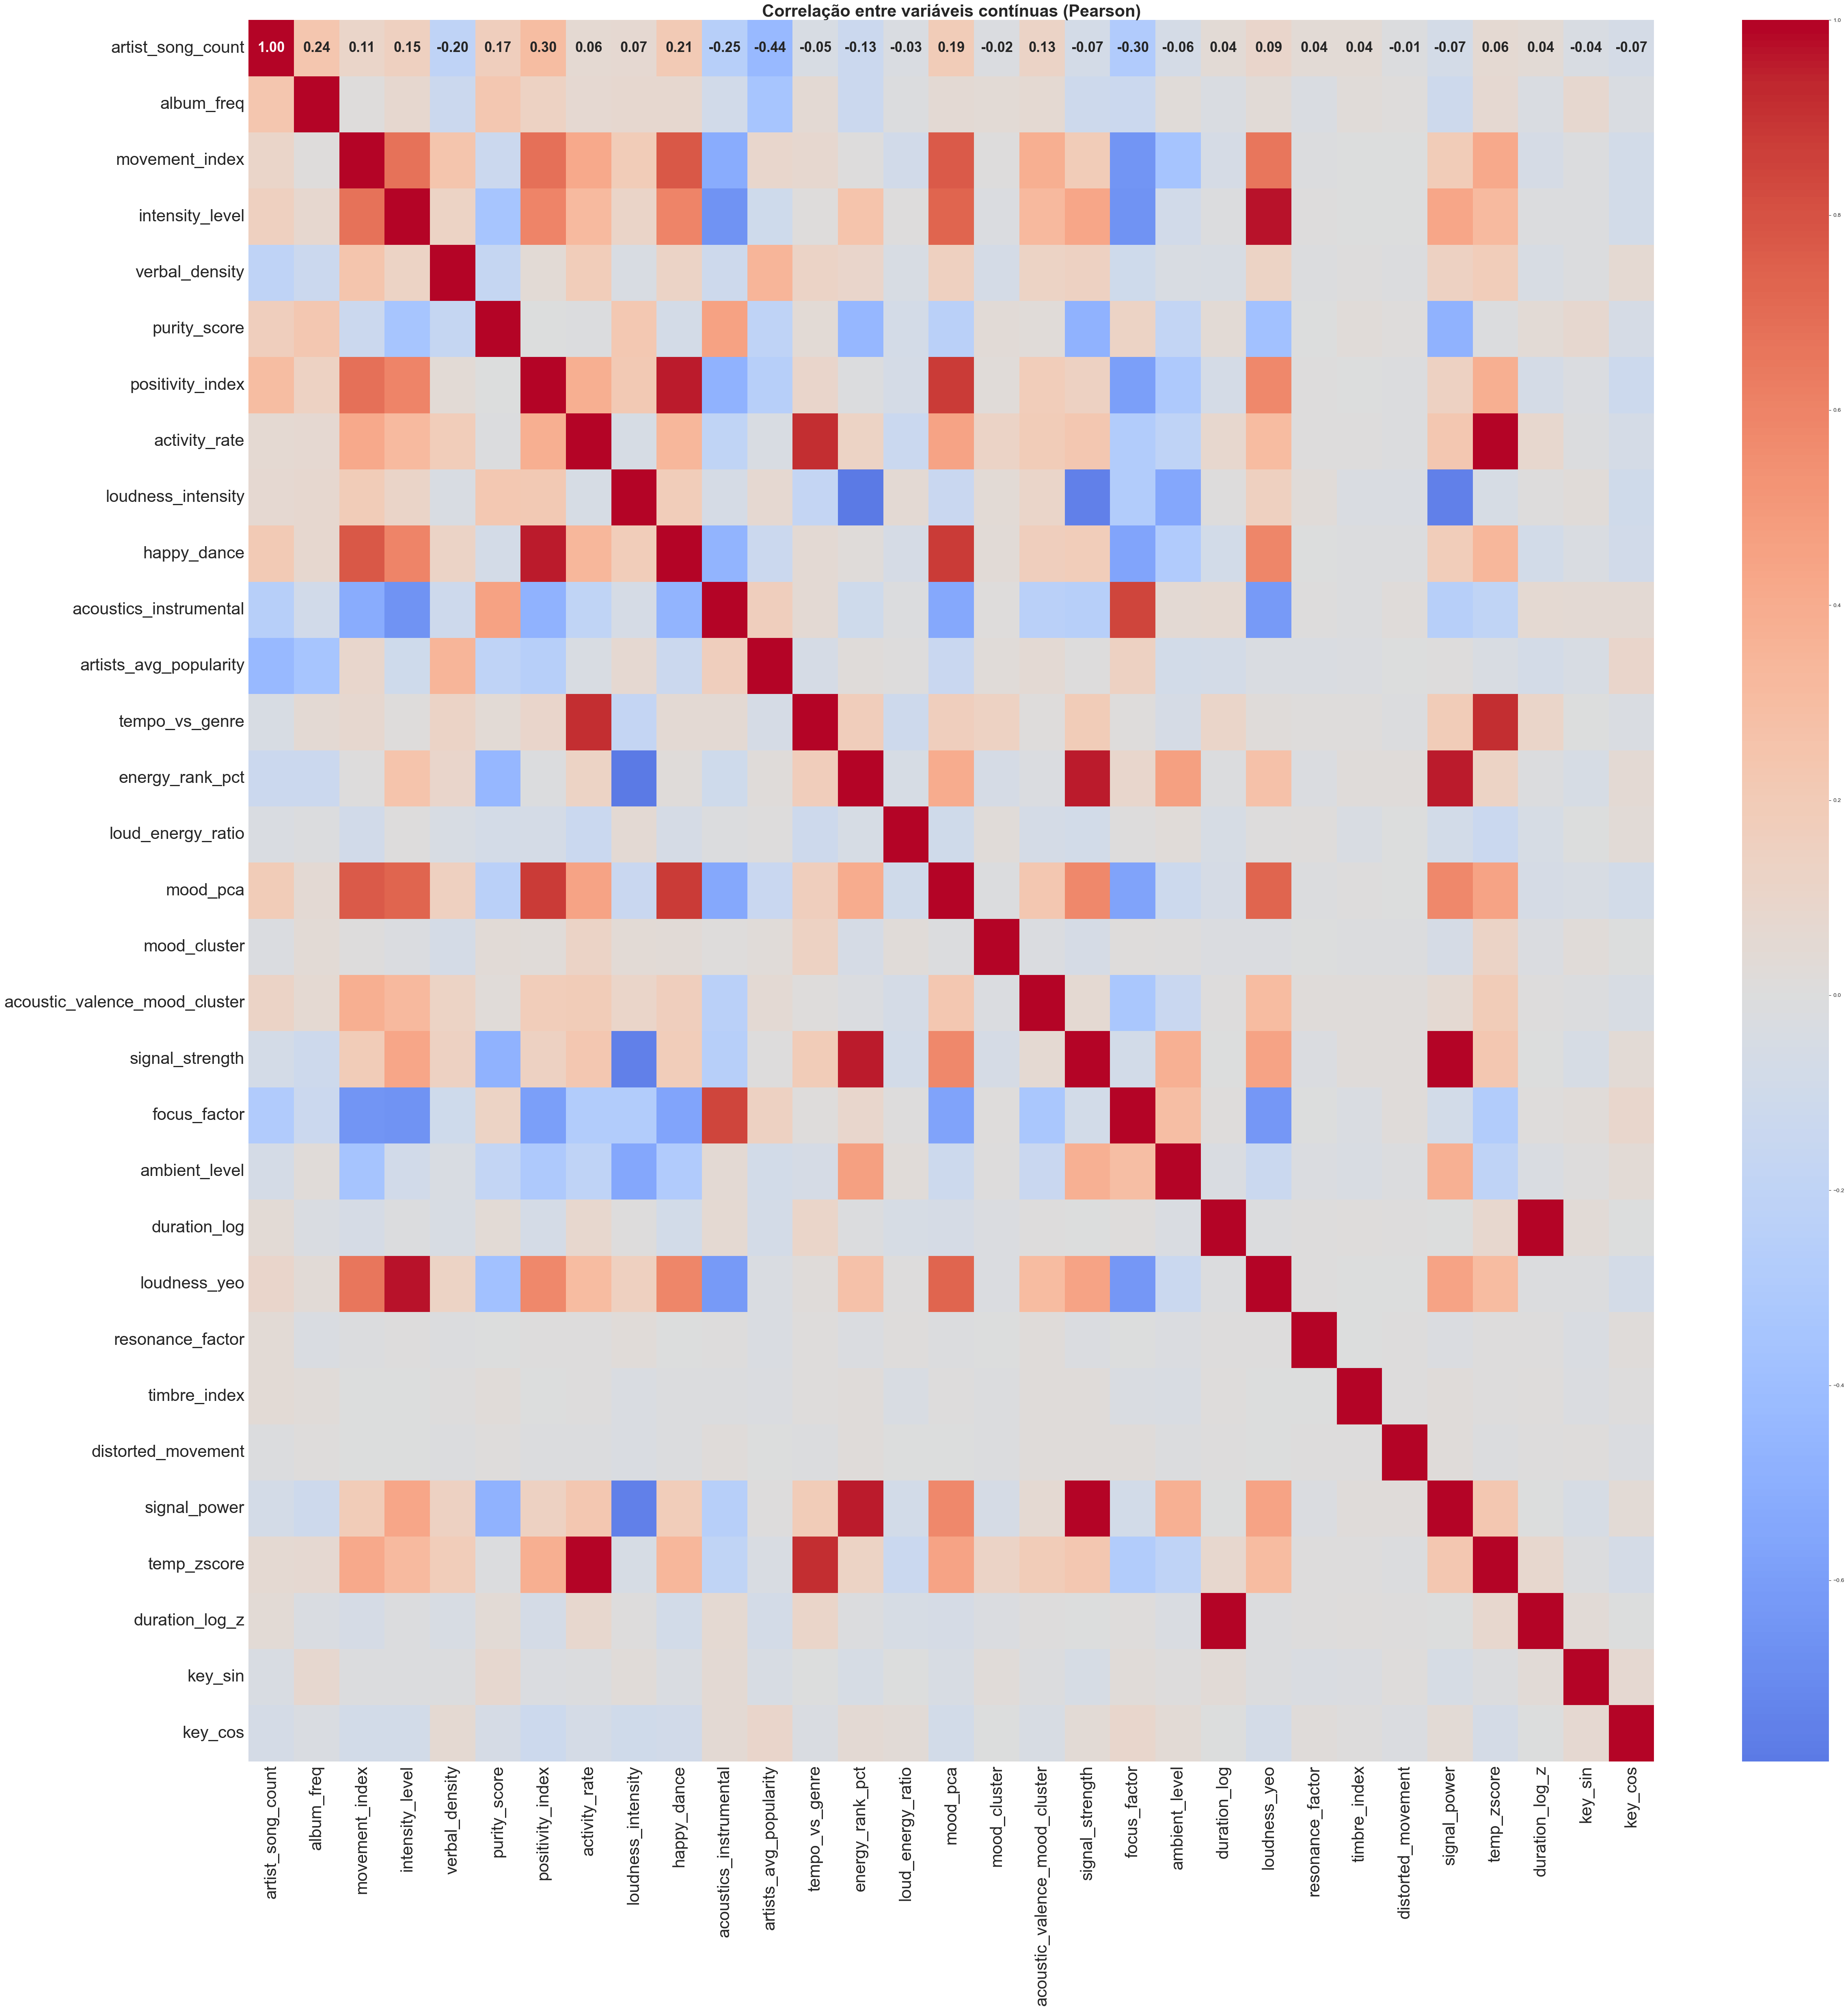

Top 10 pares de features mais correlacionados (|r| ≥ 0.80):


In [63]:
cont_corr = df[continuous_cols].corr(method='pearson')

plt.figure(figsize=(1.6*len(cont_corr.columns), 1.6*len(cont_corr)))
sns.heatmap(cont_corr, cmap='coolwarm', center=0, annot=True, fmt='.2f',
            annot_kws={'fontsize':25, 'fontweight':'bold'})
plt.title('Correlação entre variáveis contínuas (Pearson)', fontsize=30, fontweight='bold')
plt.xlabel('', fontsize=30, fontweight='bold')
plt.ylabel('', fontsize=30, fontweight='bold')
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=30, rotation=0)
plt.tight_layout()
plt.show()

limiar = 0.8  # ajuste conforme necessário
corr_pairs = (
    cont_corr.where(np.triu(np.ones(cont_corr.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlação'})
)
corr_pairs['AbsCorr'] = corr_pairs['Correlação'].abs()
corr_pairs = corr_pairs.sort_values('AbsCorr', ascending=False)

print("Top 10 pares de features mais correlacionados (|r| ≥ {:.2f}):".format(limiar))
display(
    corr_pairs[corr_pairs['AbsCorr'] >= limiar].head(10)
    .style
    .format({'Correlação': '{:.2f}', 'AbsCorr': '{:.2f}'})
    .bar(subset=['AbsCorr'], color='#8B0000')
    .set_caption('Top 10 pares de features mais correlacionados (|r| ≥ {:.2f})'.format(limiar))
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#8B0000'),
                                     ('color', 'white'),
                                     ('font-weight', 'bold'),
                                     ('text-align', 'center')]}
    ])
)

## **Conclusão** da correlação entre features  
Os “Top 10 pares” mostram colinearidades **muito altas** (|r| ≥ 0.80), incluindo correlações praticamente **perfeitas** (p.ex., `signal_strength`↔`signal_power`, `duration_log`↔`duration_log_z`, `activity_rate`↔`tempo_zscore`). Isto indica **variáveis redundantes/derivadas**  que carregam a mesma informação.

### Multicolinearidade entre features

O nosso conjunto de dados inclui várias variáveis que, apesar de diferentes nomes, acabam por medir praticamente a mesma coisa ou são versões transformadas de outras já presentes. Para evitar redundância e facilitar a interpretação dos modelos, optámos por manter apenas uma variável representativa de cada grupo de características semelhantes.

Por exemplo, mantivemos apenas as medidas base ou mais interpretáveis (como `signal_power` em vez de `signal_strength`, e `duration_log` em vez de `duration_log_z`). Também demos preferência a variáveis contínuas e originais, removendo versões padronizadas ou ranqueadas que não acrescentam informação relevante.

Com esta seleção, garantimos que os modelos ficam mais simples, estáveis e fáceis de interpretar, sem perder informação importante para as tarefas de regressão e classificação.

In [64]:
# Lista simples do que remover (só remove se a coluna existir no DF)
cols_to_drop = [
    'signal_strength',   # redundante de signal_power
    'duration_log_z',    # z-score de duration_log (o pipeline já fará scaling)
    'tempo_zscore',      # z-score do tempo; preferimos tempo_vs_genre (contexto)
    'intensity_level',   # ~loudness_yeo
    'energy_rank_pct',   # rank/percentil do mesmo constructo de energia
    'happy_dance',       # proxy de positivity_index e colinear com mood_pca
    # opcional: 'activity_rate',  # muito correlacionada com tempo_vs_genre
]

present = [c for c in cols_to_drop if c in df.columns]
df = df.drop(columns=present)

print("Removidas:", present)
print("Shape:", df.shape, "→", df.shape)


Removidas: ['signal_strength', 'duration_log_z', 'intensity_level', 'energy_rank_pct', 'happy_dance']
Shape: (2995, 42) → (2995, 42)


# 3. Methods Application – Regression

Conforme o *enunciado*, nesta secção construímos e avaliamos modelos de **regressão** para prever `target_regression` usando *hold-out*.

In [65]:
from sklearn.model_selection import train_test_split

numeric_cols = df.select_dtypes(include='number').columns.tolist()
feature_cols = [c for c in numeric_cols if c != target_regression]

X_all = df[feature_cols].copy()
y_all = df[target_regression].copy()

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.25, random_state=RANDOM_STATE
)

print("Hold-out pronto. Treino:", X_train.shape, "| Teste:", X_test.shape)


Hold-out pronto. Treino: (2246, 40) | Teste: (749, 40)


## 3.1 Simple Linear Regression

Testamos **várias *features* individualmente**. Para cada uma treinamos um modelo `LinearRegression` e avaliamos no *hold-out* com **R², MAE e RMSE**. No fim, mostramos o *ranking* e destacamos a melhor *feature*.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Função auxiliar para métricas
def _metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    return r2, mae, rmse

results_simple = []

for col in feature_cols:
    # treino com uma única coluna
    model = LinearRegression()
    model.fit(X_train[[col]], y_train)
    preds = model.predict(X_test[[col]])
    r2, mae, rmse = _metrics(y_test, preds)
    results_simple.append({'feature': col, 'R2': r2, 'MAE': mae, 'RMSE': rmse})

simple_df = pd.DataFrame(results_simple).sort_values(by=['R2', 'RMSE'], ascending=[False, True]).reset_index(drop=True)
print("Top 10 (Simple Regression):")
display(simple_df.head(10))

best_feature = simple_df.iloc[0]['feature']
print(f"\nMelhor feature (simple regression): {best_feature}")

# Modelo final com a melhor *feature*
simple_best_model = LinearRegression().fit(X_train[[best_feature]], y_train)
simple_best_pred = simple_best_model.predict(X_test[[best_feature]])
simple_best_scores = dict(zip(['R2','MAE','RMSE'], _metrics(y_test, simple_best_pred)))
print("Desempenho (melhor feature):", simple_best_scores)

Top 10 (Simple Regression):


feature        R2       MAE      RMSE
0  artists_avg_popularity  0.872881  0.177149  0.107334
1        popularity_level  0.258537  0.630844  0.626063
2                explicit  0.146620  0.715423  0.720561
3       artist_song_count  0.128438  0.706248  0.735913
4              album_freq  0.087474  0.757237  0.770502
5          verbal_density  0.083720  0.754407  0.773671
6        positivity_index  0.065669  0.766162  0.788913
7          mode_indicator  0.058064  0.761318  0.795334
8            purity_score  0.043503  0.783021  0.807629
9  acoustics_instrumental  0.022391  0.792169  0.825455


Melhor feature (simple regression): artists_avg_popularity
Desempenho (melhor feature): {'R2': 0.8728809253783133, 'MAE': 0.17714880186700876, 'RMSE': 0.10733445454669482}


c:\Users\flavi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


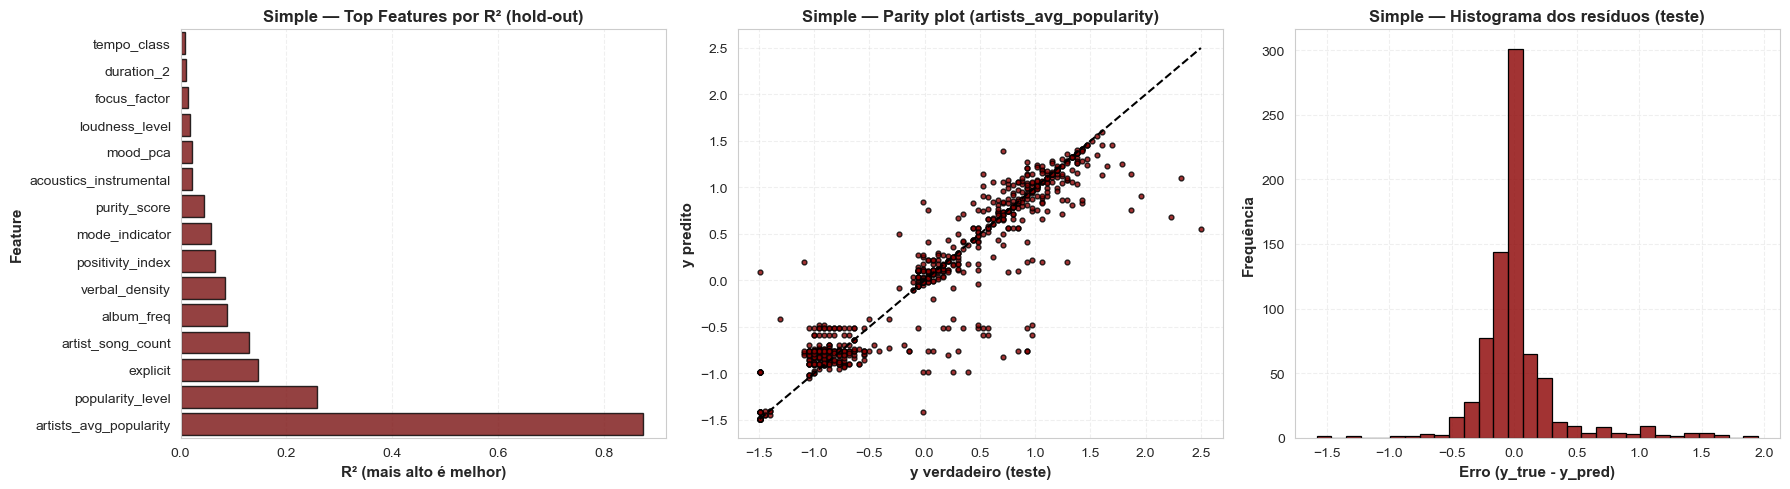

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Definir o número máximo de Top-N
_top_n = min(15, len(simple_df))

# Criando uma figura com 1 linha e 3 colunas de gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Ranking por R² (Top-N) - Gráfico de barras horizontais
sns.barplot(data=simple_df.sort_values('R2', ascending=True).tail(_top_n), 
            x='R2', y='feature', color='#8B0000', edgecolor='black', alpha=0.8, ax=axes[0])
axes[0].set_title('Simple — Top Features por R² (hold-out)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('R² (mais alto é melhor)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Feature', fontsize=11, fontweight='bold')
axes[0].grid(axis='x', linestyle='--', alpha=0.3)

# Parity plot (melhor feature)
_simple_best = LinearRegression().fit(X_train[[best_feature]], y_train)
_simple_pred = _simple_best.predict(X_test[[best_feature]])

axes[1].scatter(y_test, _simple_pred, s=12, color='#8B0000', edgecolor='black', alpha=0.8)
_min = min(y_test.min(), _simple_pred.min())
_max = max(y_test.max(), _simple_pred.max())
axes[1].plot([_min, _max], [_min, _max], color='black', linestyle='--')
axes[1].set_title(f'Simple — Parity plot ({best_feature})', fontsize=12, fontweight='bold')
axes[1].set_xlabel('y verdadeiro (teste)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('y predito', fontsize=11, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.3)

# Histograma de resíduos
resid = y_test - _simple_pred
sns.histplot(resid, bins=30, color='#8B0000', edgecolor='black', alpha=0.8, ax=axes[2])
axes[2].set_title('Simple — Histograma dos resíduos (teste)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Erro (y_true - y_pred)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Frequência', fontsize=11, fontweight='bold')
axes[2].grid(True, linestyle='--', alpha=0.3)

# Ajuste do layout para evitar sobreposição
plt.tight_layout()
plt.show()


## 3.2 Multiple Linear Regression

Avaliamos diferentes **conjuntos de *features***:
- **Todas** as *features* numéricas;
- Top-*k* por correlação de Pearson com a variável alvo (`k ∈ {3,5,10}`);
- `SelectKBest(f_regression)` com `k ∈ {3,5,10}`.

Usamos o mesmo *hold-out* para comparação direta.

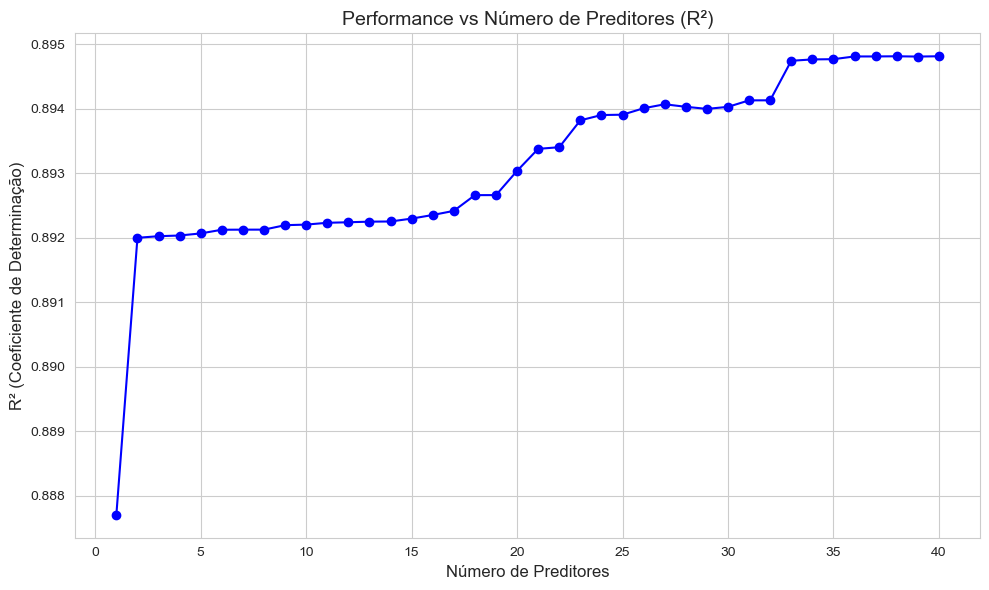

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression

# Calculando a performance (R2) vs número de preditores
n_features_range = range(1, len(feature_cols) + 1)
r2_scores = []

for n_features in n_features_range:
    best_features = SelectKBest(f_regression, k=n_features).fit(X_train, y_train)
    selected_features = [feature_cols[i] for i in best_features.get_support(indices=True)]
    
    # Treinar o modelo com as features selecionadas
    X_train_selected = X_train[selected_features]
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    # Calcular R^2
    r2_scores.append(model.score(X_train_selected, y_train))

# Plot da performance vs número de preditores
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_features_range, r2_scores, marker='o', linestyle='-', color='b')
ax.set_title('Performance vs Número de Preditores (R²)')
ax.set_xlabel('Número de Preditores')
ax.set_ylabel('R² (Coeficiente de Determinação)')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

def _eval_set(name, cols):
    model = LinearRegression()
    model.fit(X_train[cols], y_train)
    preds = model.predict(X_test[cols])
    r2, mae, rmse = _metrics(y_test, preds)
    return {'set': name, 'n_features': len(cols), 'R2': r2, 'MAE': mae, 'RMSE': rmse, 'features': cols}

experiments = []

# (A) Todas as *features*
experiments.append(_eval_set("all_numeric", feature_cols))

# (B) Top-k por |correlação| com y
corrs = {}
for c in feature_cols:
    corrs[c] = np.corrcoef(X_train[c], y_train)[0,1]

corr_sorted = [c for c,_ in sorted(corrs.items(), key=lambda kv: (abs(kv[1]) if kv[1]==kv[1] else -1), reverse=True)]
for k in [3,5,10]:
    cols_k = corr_sorted[:min(k, len(corr_sorted))]
    experiments.append(_eval_set(f"pearson_top_{len(cols_k)}", cols_k))

# (C) SelectKBest (f_regression)
for k in [3,5,10]:
    k_eff = min(k, len(feature_cols))
    skb = SelectKBest(score_func=f_regression, k=k_eff)
    skb.fit(X_train[feature_cols], y_train)
    mask = skb.get_support(indices=True)
    cols_k = [feature_cols[i] for i in mask]
    experiments.append(_eval_set(f"selectkbest_{len(cols_k)}", cols_k))

multi_df = pd.DataFrame(experiments).sort_values(by=['R2','RMSE'], ascending=[False, True]).reset_index(drop=True)
print("Resultados (Multiple Regression) — ordenado por R² desc e RMSE asc:")
display(multi_df[['set','n_features','R2','MAE','RMSE']].head(10))

best_row = multi_df.iloc[0]
best_set_name = best_row['set']
best_set_cols = best_row['features']
print(f"\nMelhor conjunto: {best_set_name} (n={len(best_set_cols)})")
r2_values = []

for feature in best_set_cols:
    model = LinearRegression()
    model.fit(X_train[[feature]], y_train)
    preds = model.predict(X_test[[feature]])
    r2 = r2_score(y_test, preds)
    r2_values.append((feature, r2))

best_set_cols_sorted = [x[0] for x in sorted(r2_values, key=lambda x: x[1], reverse=True)]

print(f"\nMelhor conjunto de preditores ordenado por R2:")
print(best_set_cols_sorted)

Resultados (Multiple Regression) — ordenado por R² desc e RMSE asc:


set  n_features        R2       MAE      RMSE
0     all_numeric          40  0.884316  0.186077  0.097679
1  selectkbest_10          10  0.881762  0.184899  0.099835
2  pearson_top_10          10  0.881762  0.184899  0.099835
3   pearson_top_3           3  0.881606  0.184944  0.099967
4   selectkbest_3           3  0.881606  0.184944  0.099967
5   selectkbest_5           5  0.881471  0.185246  0.100081
6   pearson_top_5           5  0.881471  0.185246  0.100081


Melhor conjunto: all_numeric (n=40)

Melhor conjunto de preditores ordenado por R²:
['artists_avg_popularity', 'popularity_level', 'explicit', 'artist_song_count', 'album_freq', 'verbal_density', 'positivity_index', 'mode_indicator', 'purity_score', 'acoustics_instrumental', 'mood_pca', 'loudness_level', 'focus_factor', 'duration_2', 'tempo_class', 'is_instrumental', 'ambient_level', 'key_sin', 'key_cos', 'loudness_intensity', 'duration_log', 'time_signature_class_boolean', 'tempo_vs_genre', 'acoustic_valence_mood_cluster', 'mood_cluster', 'duration_5', 'activity_rate', 'temp_zscore', 'loudness_yeo', 'duration_1', 'duration_4', 'movement_index', 'loud_energy_ratio', 'signal_power', 'time_signature', 'distorted_movement', 'duration_3', 'key_mode', 'timbre_index', 'resonance_factor']


c:\Users\flavi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


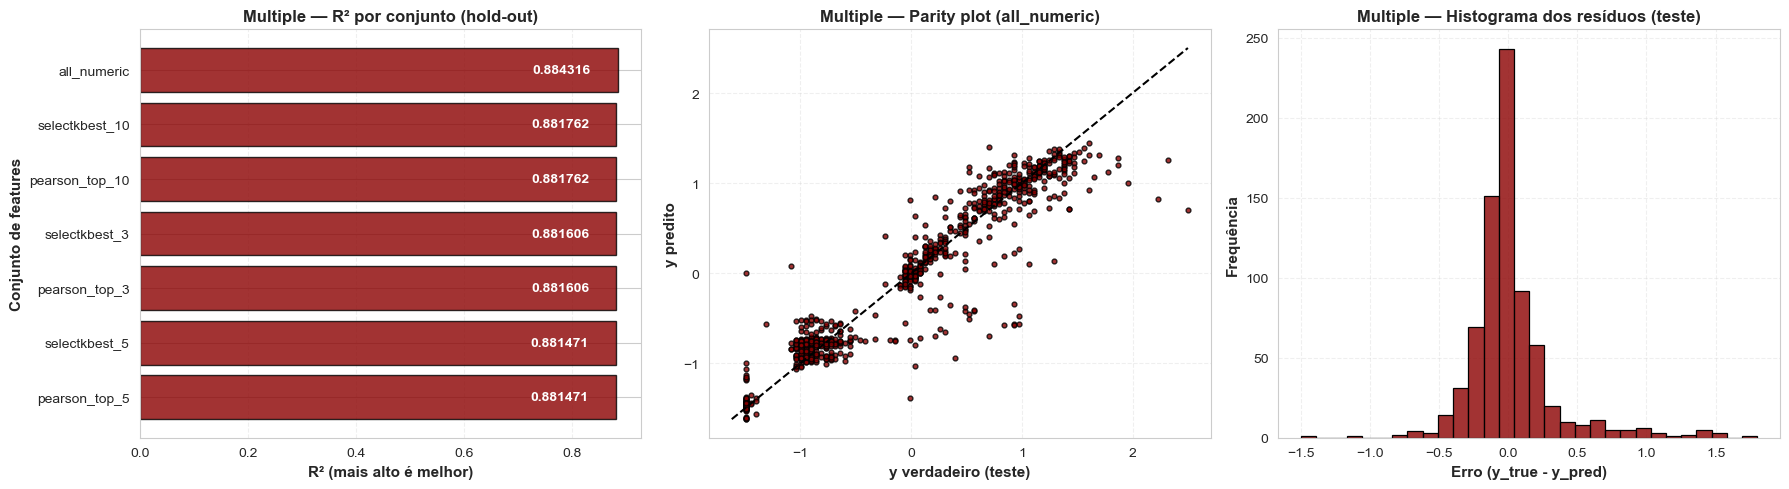

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Preparando os dados e criando a figura com 1 linha e 3 colunas de gráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Ajuste do tamanho da figura para 3 gráficos lado a lado

# R² - Gráfico de barras horizontais
_multi_plot_df = multi_df[['set', 'R2']].copy().sort_values('R2', ascending=True)
bars = axes[0].barh(_multi_plot_df['set'], _multi_plot_df['R2'], color='#8B0000', edgecolor='black', alpha=0.8)

# Adicionando os valores dentro de cada barra
for bar in bars:
    axes[0].text(bar.get_width() - 0.05,  # Posição X (um pouco antes do final da barra)
                 bar.get_y() + bar.get_height() / 2,  # Posição Y (meio da barra)
                 f'{bar.get_width():.6f}',  # Valor a ser exibido
                 va='center', ha='right',  # Alinhamento vertical e horizontal
                 color='white', fontsize=10, fontweight='bold')

# Configurações do gráfico de R²
axes[0].set_title('Multiple — R² por conjunto (hold-out)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('R² (mais alto é melhor)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Conjunto de features', fontsize=11, fontweight='bold')
axes[0].grid(axis='x', linestyle='--', alpha=0.3)

# Parity plot (melhor conjunto)
_multi_best = LinearRegression().fit(X_train[best_set_cols], y_train)
_multi_pred = _multi_best.predict(X_test[best_set_cols])

axes[1].scatter(y_test, _multi_pred, s=12, color='#8B0000', edgecolor='black', alpha=0.8)
_min = min(y_test.min(), _multi_pred.min())
_max = max(y_test.max(), _multi_pred.max())
axes[1].plot([_min, _max], [_min, _max], color='black', linestyle='--')
axes[1].set_title(f'Multiple — Parity plot ({best_set_name})', fontsize=12, fontweight='bold')
axes[1].set_xlabel('y verdadeiro (teste)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('y predito', fontsize=11, fontweight='bold')
axes[1].grid(True, linestyle='--', alpha=0.3)

# Histograma dos resíduos
resid_m = y_test - _multi_pred
sns.histplot(resid_m, bins=30, color='#8B0000', edgecolor='black', alpha=0.8, ax=axes[2])
axes[2].set_title('Multiple — Histograma dos resíduos (teste)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Erro (y_true - y_pred)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Frequência', fontsize=11, fontweight='bold')
axes[2].grid(True, linestyle='--', alpha=0.3)

# Ajuste do layout para evitar sobreposição
plt.tight_layout()
plt.show()


## 3.3 Comparação entre Modelos de Regressão

A tabela abaixo junta o **melhor Simple** (1 *feature*) e o **melhor Multiple** (várias *features*) para facilitar a comparação por **R², MAE e RMSE**.



In [ ]:
# Reconstituir as métricas do best simple
best_simple_row = simple_df.iloc[0]
best_simple_name = f"simple::{best_simple_row['feature']}"
best_simple_scores = {'R2': best_simple_row['R2'], 'MAE': best_simple_row['MAE'], 'RMSE': best_simple_row['RMSE']}

# Métricas do best multiple já estão em best_row
best_multiple_scores = {'R2': best_row['R2'], 'MAE': best_row['MAE'], 'RMSE': best_row['RMSE']}

summary = pd.DataFrame([
    {'Model': best_simple_name, **best_simple_scores},
    {'Model': f"multiple::{best_set_name}", **best_multiple_scores},
]).sort_values(by=['R2','RMSE'], ascending=[False, True]).reset_index(drop=True)

print("Resumo (melhores modelos):")
display(summary)


Resumo (melhores modelos):


Model        R2       MAE      RMSE
0           multiple::all_numeric  0.884316  0.186077  0.097679
1  simple::artists_avg_popularity  0.872881  0.177149  0.107334

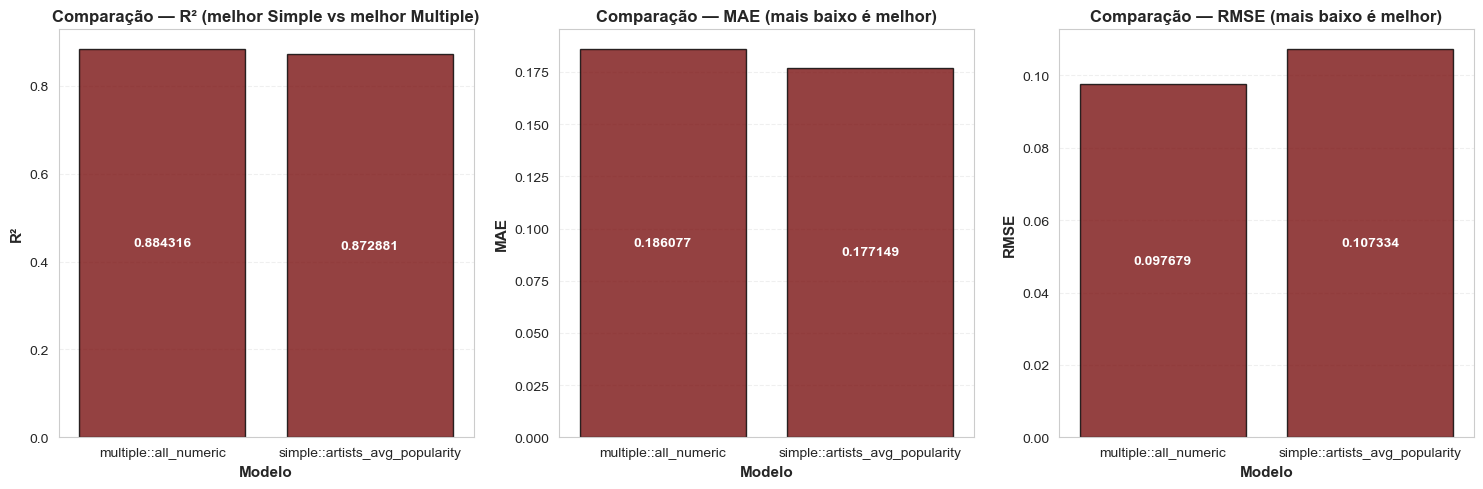

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que '_summary_df' seja o seu DataFrame
_summary_df = summary.copy()

# Criando uma figura com 1 linha e 3 colunas de gráficos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R²
sns.barplot(data=_summary_df, x='Model', y='R2', color='#8B0000', edgecolor='black', alpha=0.8, ax=axes[0])
axes[0].set_title('Comparação — R² (melhor Simple vs melhor Multiple)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Modelo', fontsize=11, fontweight='bold')
axes[0].set_ylabel('R²', fontsize=11, fontweight='bold')
axes[0].grid(axis='y', linestyle='--', alpha=0.3)

# Adicionando valores dentro das barras para R²
for bar in axes[0].patches:
    axes[0].text(bar.get_x() + bar.get_width() / 2, 
                 bar.get_height() / 2 + bar.get_y(),  # Centralizando o texto dentro da barra
                 f'{bar.get_height():.6f}',  # Exibindo o valor com 6 casas decimais
                 ha='center', va='center',  # Alinhamento central do texto
                 color='white', fontsize=10, fontweight='bold')

# MAE
sns.barplot(data=_summary_df, x='Model', y='MAE', color='#8B0000', edgecolor='black', alpha=0.8, ax=axes[1])
axes[1].set_title('Comparação — MAE (mais baixo é melhor)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Modelo', fontsize=11, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[1].grid(axis='y', linestyle='--', alpha=0.3)

# Adicionando valores dentro das barras para MAE
for bar in axes[1].patches:
    axes[1].text(bar.get_x() + bar.get_width() / 2, 
                 bar.get_height() / 2 + bar.get_y(),  # Centralizando o texto dentro da barra
                 f'{bar.get_height():.6f}',  # Exibindo o valor com 6 casas decimais
                 ha='center', va='center',  # Alinhamento central do texto
                 color='white', fontsize=10, fontweight='bold')

# RMSE
sns.barplot(data=_summary_df, x='Model', y='RMSE', color='#8B0000', edgecolor='black', alpha=0.8, ax=axes[2])
axes[2].set_title('Comparação — RMSE (mais baixo é melhor)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Modelo', fontsize=11, fontweight='bold')
axes[2].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[2].grid(axis='y', linestyle='--', alpha=0.3)

# Adicionando valores dentro das barras para RMSE
for bar in axes[2].patches:
    axes[2].text(bar.get_x() + bar.get_width() / 2, 
                 bar.get_height() / 2 + bar.get_y(),  # Centralizando o texto dentro da barra
                 f'{bar.get_height():.6f}',  # Exibindo o valor com 6 casas decimais
                 ha='center', va='center',  # Alinhamento central do texto
                 color='white', fontsize=10, fontweight='bold')

# Ajuste do layout para evitar sobreposição
plt.tight_layout()
plt.show()



# 4. Methods Application – Classification

Conforme o enunciado, nesta secção comparamos **Logistic Regression (LR)**, **Linear Discriminant Analysis (LDA)** e **Quadratic Discriminant Analysis (QDA)** sob diferentes **métodos de reamostragem** (*Holdout*, **CV k=5**, **CV k=10**, **LOOCV** e **Bootstrap**), avaliando desempenho e a **variância** associada a cada esquema.


c:\Users\flavi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\flavi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\flavi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\flavi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\flavi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\flavi\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\flavi\anaconda3\Lib\site-

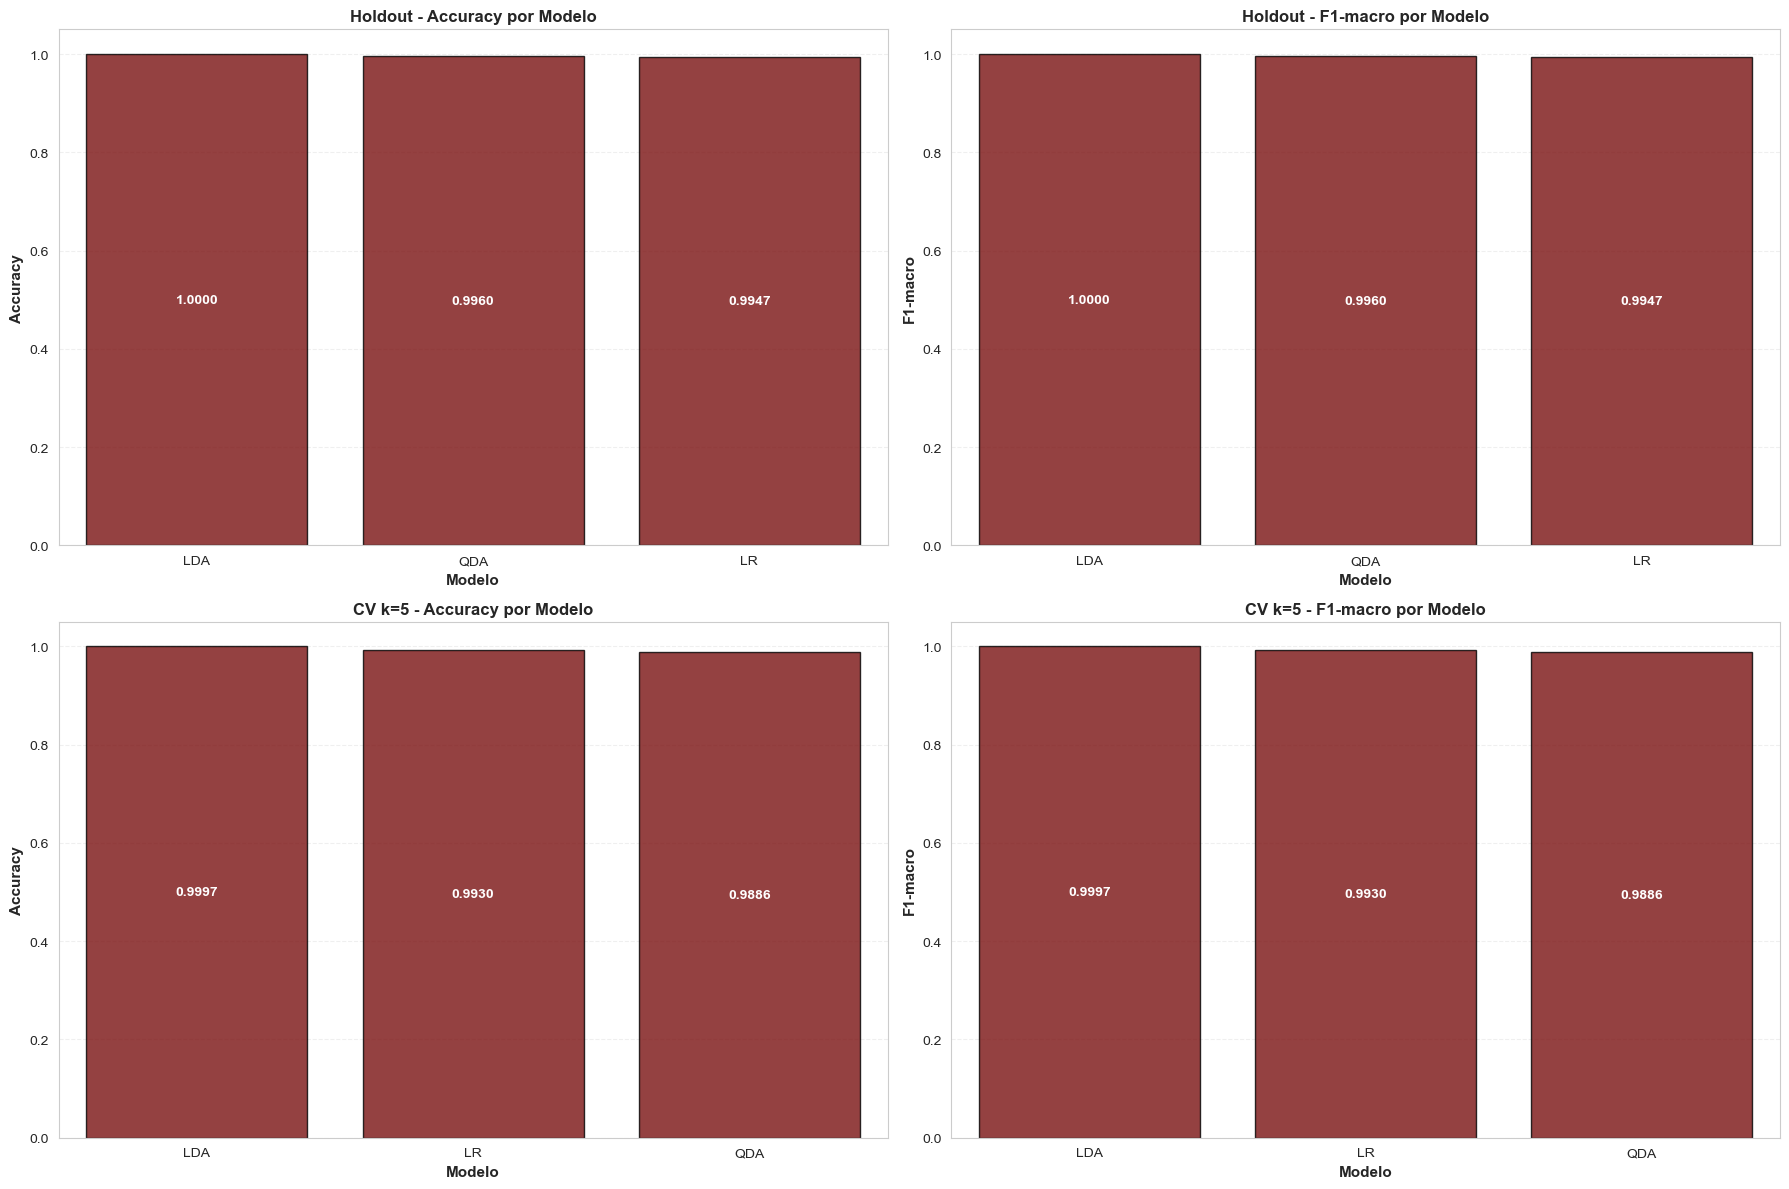

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

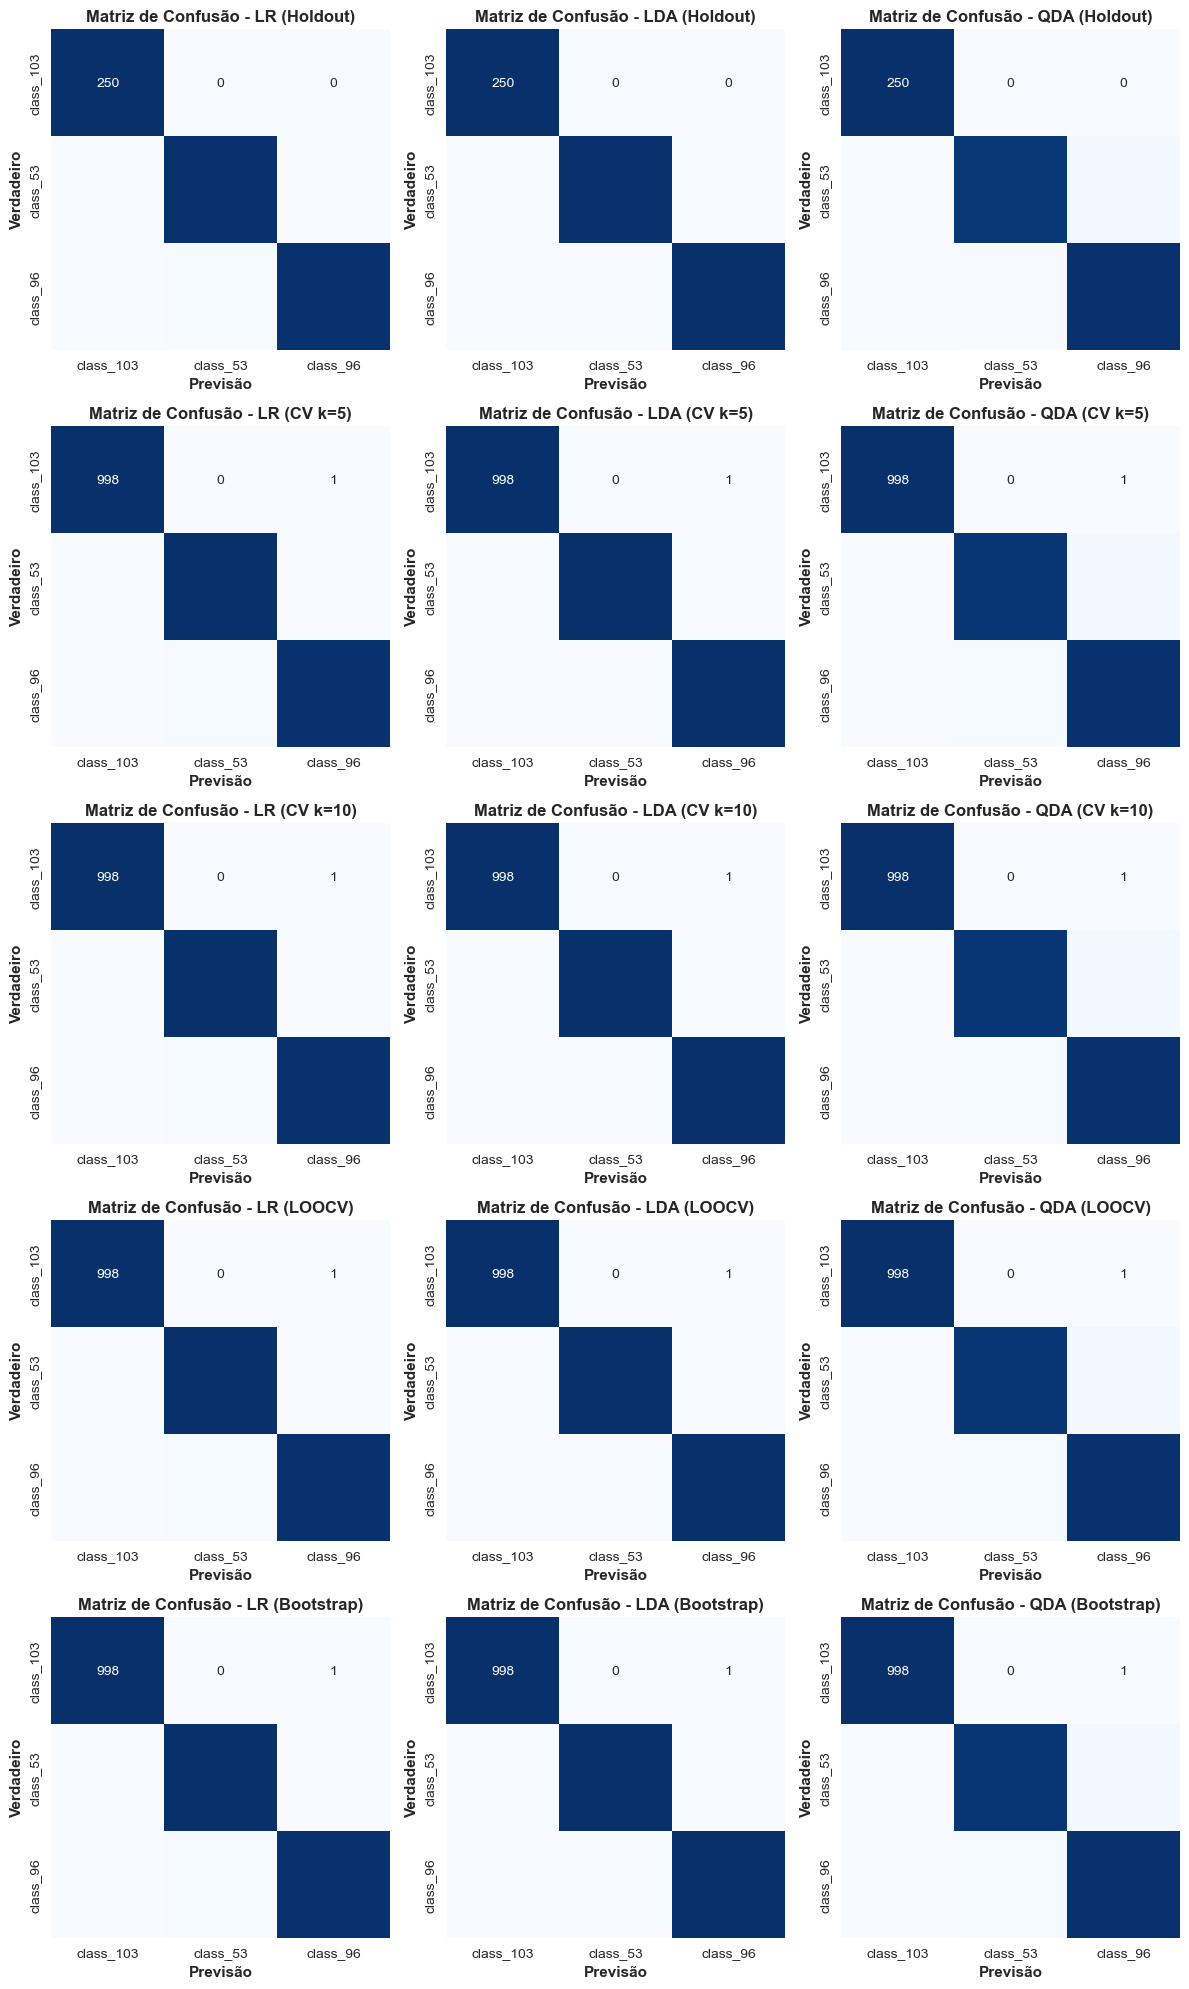

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

# Definindo as variáveis e separando os dados
target_cls = 'target_class'
exclude_cols = {'target_regression', target_cls}
feature_cols = [c for c in df.select_dtypes(include='number').columns if c not in exclude_cols]

Xc_all = df[feature_cols_cls].copy()
yc_all = df[target_cls].copy()

Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(
    Xc_all, yc_all, test_size=0.25, random_state=42, stratify=yc_all
)
classes_ = sorted(yc_all.unique())

# Modelos a utilizar
models = {
    "LR":  LogisticRegression(max_iter=1000, multi_class='auto'),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(reg_param=1e-3),
}

# HOLDOUT
rows_holdout = []
for name, mdl in models.items():
    mdl.fit(Xc_tr, yc_tr)
    ypred = mdl.predict(Xc_te)
    acc = accuracy_score(yc_te, ypred)
    f1m = f1_score(yc_te, ypred, average='macro')
    auc = np.nan
    if hasattr(mdl, "predict_proba"):
        proba = mdl.predict_proba(Xc_te)
        auc = roc_auc_score(yc_te, proba, multi_class='ovr')
    elif hasattr(mdl, "decision_function"):
        dec = mdl.decision_function(Xc_te)
        auc = roc_auc_score(yc_te, dec, multi_class='ovr')
    cm = confusion_matrix(yc_te, ypred, labels=classes_)
    rows_holdout.append({"model": name, "acc": acc, "f1_macro": f1m, "auc_ovr": auc})

# CV k=5 e k=10
rows_cv5, rows_cv10 = [], []
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, mdl in models.items():
    acc5 = cross_val_score(mdl, Xc_all, yc_all, cv=cv5, scoring="accuracy")
    f1m5 = cross_val_score(mdl, Xc_all, yc_all, cv=cv5, scoring="f1_macro")
    rows_cv5.append({"model": name, "acc_mean": acc5.mean(), "acc_std": acc5.std(),
                     "f1m_mean": f1m5.mean(), "f1m_std": f1m5.std()})
    acc10 = cross_val_score(mdl, Xc_all, yc_all, cv=cv10, scoring="accuracy")
    f1m10 = cross_val_score(mdl, Xc_all, yc_all, cv=cv10, scoring="f1_macro")
    rows_cv10.append({"model": name, "acc_mean": acc10.mean(), "acc_std": acc10.std(),
                      "f1m_mean": f1m10.mean(), "f1m_std": f1m10.std()})

# LOOCV
rows_loocv = []
loo = LeaveOneOut()
for name, mdl in models.items():
    acc_lo = cross_val_score(mdl, Xc_all, yc_all, cv=loo, scoring="accuracy")
    rows_loocv.append({"model": name, "acc_mean": acc_lo.mean(), "acc_std": acc_lo.std()})

# Bootstrap OOB
def _bootstrap_oob_acc(model, X, y, B=200, seed=42):
    rng = np.random.RandomState(seed)
    n = len(y)
    accs = []
    for _ in range(B):
        idx = rng.randint(0, n, size=n)
        oob = np.ones(n, dtype=bool); oob[idx] = False
        if not oob.any():
            continue
        Xb, yb = X.iloc[idx], y.iloc[idx]
        Xo, yo = X.iloc[oob], y.iloc[oob]
        model.fit(Xb, yb)
        accs.append(accuracy_score(yo, model.predict(Xo)))
    return np.array(accs)

rows_boot = []
for name, mdl in models.items():
    accs = _bootstrap_oob_acc(mdl, Xc_all, yc_all, B=200, seed=42)
    rows_boot.append({"model": name, "acc_mean": float(np.mean(accs)), "acc_std": float(np.std(accs)), "B_eff": int(len(accs))})

# Tabelas resumo
tab_holdout = pd.DataFrame(rows_holdout).sort_values(by=["acc","f1_macro"], ascending=False).reset_index(drop=True)
tab_cv5    = pd.DataFrame(rows_cv5).sort_values(by=["acc_mean","f1m_mean"], ascending=False).reset_index(drop=True)
tab_cv10   = pd.DataFrame(rows_cv10).sort_values(by=["acc_mean","f1m_mean"], ascending=False).reset_index(drop=True)
tab_loocv  = pd.DataFrame(rows_loocv).sort_values(by=["acc_mean"], ascending=False).reset_index(drop=True)
tab_boot   = pd.DataFrame(rows_boot).sort_values(by=["acc_mean"], ascending=False).reset_index(drop=True)

# Gráficos de barras para os resultados das validações
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Holdout: Accuracy e F1-macro
sns.barplot(data=tab_holdout, x='model', y='acc', ax=axes[0, 0], color='#8B0000', edgecolor='black', alpha=0.8)
axes[0, 0].set_title('Holdout - Accuracy por Modelo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Modelo', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.3)

# Adicionando valores dentro de cada barra (Holdout - Accuracy)
for bar in axes[0, 0].patches:
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2 + bar.get_y(),
                    f'{bar.get_height():.4f}', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

sns.barplot(data=tab_holdout, x='model', y='f1_macro', ax=axes[0, 1], color='#8B0000', edgecolor='black', alpha=0.8)
axes[0, 1].set_title('Holdout - F1-macro por Modelo', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Modelo', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('F1-macro', fontsize=11, fontweight='bold')
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.3)

# Adicionando valores dentro de cada barra (Holdout - F1-macro)
for bar in axes[0, 1].patches:
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2 + bar.get_y(),
                    f'{bar.get_height():.4f}', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

# CV k=5: Accuracy e F1-macro
sns.barplot(data=tab_cv5, x='model', y='acc_mean', ax=axes[1, 0], color='#8B0000', edgecolor='black', alpha=0.8)
axes[1, 0].set_title('CV k=5 - Accuracy por Modelo', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Modelo', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.3)

# Adicionando valores dentro de cada barra (CV k=5 - Accuracy)
for bar in axes[1, 0].patches:
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2 + bar.get_y(),
                    f'{bar.get_height():.4f}', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

sns.barplot(data=tab_cv5, x='model', y='f1m_mean', ax=axes[1, 1], color='#8B0000', edgecolor='black', alpha=0.8)
axes[1, 1].set_title('CV k=5 - F1-macro por Modelo', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Modelo', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('F1-macro', fontsize=11, fontweight='bold')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.3)

# Adicionando valores dentro de cada barra (CV k=5 - F1-macro)
for bar in axes[1, 1].patches:
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2 + bar.get_y(),
                    f'{bar.get_height():.4f}', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# LOOCV: Accuracy
sns.barplot(data=tab_loocv, x='model', y='acc_mean', ax=axes[1, 0], color='#8B0000', edgecolor='black', alpha=0.8)
axes[1, 0].set_title('LOOCV - Accuracy por Modelo', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Modelo', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.3)

# Adicionando valores dentro de cada barra (LOOCV - Accuracy)
for bar in axes[1, 0].patches:
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2 + bar.get_y(),
                    f'{bar.get_height():.4f}', ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    
plt.tight_layout()
plt.show()

# Bootstrap: Boxplot para Accuracy
sns.boxplot(data=tab_boot, x='model', y='acc_mean', ax=axes[1, 1], color='#8B0000', width=0.5)
axes[1, 1].set_title('Bootstrap - Accuracy por Modelo', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Modelo', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(5, len(models), figsize=(4*len(models), 20))

# Plotar matrizes de confusão para todos os tipos de validação lado a lado
def plot_confusion_matrix(model_name, mdl, X, y_true, validation_type, ax):
    ypred = mdl.predict(X)
    cm = confusion_matrix(y_true, ypred, labels=classes_)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes_, yticklabels=classes_, cbar=False, ax=ax)
    ax.set_title(f'Matriz de Confusão - {model_name} ({validation_type})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Previsão', fontsize=11, fontweight='bold')
    ax.set_ylabel('Verdadeiro', fontsize=11, fontweight='bold')

# Plotar matrizes de confusão para todos os tipos de validação
for idx, model_name in enumerate(models):
    mdl = models[model_name]
    plot_confusion_matrix(model_name, mdl, Xc_te, yc_te, 'Holdout', axes[0, idx])
    plot_confusion_matrix(model_name, mdl, Xc_all, yc_all, 'CV k=5', axes[1, idx])
    plot_confusion_matrix(model_name, mdl, Xc_all, yc_all, 'CV k=10', axes[2, idx])
    plot_confusion_matrix(model_name, mdl, Xc_all, yc_all, 'LOOCV', axes[3, idx])
    plot_confusion_matrix(model_name, mdl, Xc_all, yc_all, 'Bootstrap', axes[4, idx])

plt.tight_layout()
plt.show()



**Conclusões**

- Em **CV k=10**, holdout e bootstrap apresentam resultados consistentes → indica boa generalização
- Em **CV k=10**, o melhor desempenho médio (Accuracy/F1-macro) foi consistente com os resultados do holdout e do **Bootstrap OOB**; isto sustenta a **generalização** do modelo selecionado
- O **boxplot OOB** evidenciou a **dispersão** do desempenho por modelo: menor dispersão implica maior **robustez**

**Escolha recomendada:** adotar o modelo com melhor accuracy em CV k=10 - **LDA** - tendo sido essa decisão validada pelo *holdout* e pela estabilidade observada no **Bootstrap**.


# Feature selection

## Regularização para Seleção de Features (L1 vs L2) — Classificação

**Objetivo.** Verificar se **usar um subconjunto de features** (escolhidas por métodos de regularização) pode **melhorar o desempenho** face a usar **todas as features**.

**Métodos comparados:**
- **ALL (L2)** — Logistic Regression com **Ridge (L2)** usando **todas** as features (baseline regularizado).
- **FS LASSO→L2** — **Lasso (L1)** para *seleção* (coeficientes a 0) e, depois, Logistic Regression **L2** para classificar.
- **FS RIDGE→L2** — “Seleção” baseada na **importância L2** (|coef|) com *cutoff* na **mediana**, seguida de Logistic Regression **L2**.

**Avaliação.** 

Validação cruzada **estratificada k=10** (externa), com **Accuracy** e **F1-macro** (classes balanceadas).  
Escalonamento (**StandardScaler**) aplicado **dentro das pipelines** para evitar *data leakage*.


In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1. Definir alvo e features
# =========================

# Nome da coluna da classe (ajusta se for diferente no teu dataset)
target_cls = 'target_class'

# Se tens outra variável alvo (ex: regressão) que não queres usar aqui:
exclude_cols = {'target_regression', target_cls}

# Vamos usar só features numéricas (LogReg precisa de números)
feature_cols_cls = [
    c for c in df.select_dtypes(include='number').columns
    if c not in exclude_cols
]

Xc = df[feature_cols_cls].copy()
yc = df[target_cls].copy()

print("Shape X:", Xc.shape)
print("Shape y:", yc.shape)
print("Classes:", yc.unique())

# =========================
# 2. Definir cross-validation estratificada
# =========================
cv_outer = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
)

# Vamos precisar disto para os plots
class_labels = [f"class_{c}" for c in sorted(yc.unique())]


Shape X: (2995, 40)
Shape y: (2995,)
Classes: ['class_53' 'class_96' 'class_103']


### Detalhes

- **Pipelines**: `StandardScaler` **dentro** para cada *fold* da CV (sem *leakage*).
- **Tuning automático** com `LogisticRegressionCV` (CV interna de 5 folds).
- **Três abordagens**:
  1) **ALL (L2)** — baseline “todas as features” (Ridge).
  2) **FS LASSO→L2** — *seleção* por L1 (sparse), classificação com L2.
  3) **FS RIDGE→L2** — *seleção* por L2 via *cutoff* na mediana de |coef|, classificação com L2.


In [ ]:
from sklearn.pipeline import Pipeline

# Valores de C que a LogisticRegressionCV vai testar (ajusta se já tinhas algo específico)
Cs = np.logspace(-3, 3, 10)  # por ex: [0.001 ... 1000]

# -----------------------------------------------------------------------------
# Pipeline 1: usar TODAS as features + regularização L2 (baseline)
# -----------------------------------------------------------------------------
pipe_all_L2 = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        Cs=Cs,
        cv=5,
        penalty="l2",
        solver="lbfgs",
        multi_class="ovr",
        max_iter=5000,
        scoring="f1_macro",
        n_jobs=-1
    ))
])

# -----------------------------------------------------------------------------
# Pipeline 2: SELEÇÃO DE FEATURES usando L1 (LASSO) -> depois modelo final L2
# -----------------------------------------------------------------------------
pipe_fs_l1 = Pipeline([
    ("scaler", StandardScaler()),
    ("fs", SelectFromModel(
        estimator=LogisticRegressionCV(
            Cs=Cs,
            cv=5,
            penalty="l1",          # L1 faz sparsity: zera features irrelevantes
            solver="saga",         # saga suporta L1
            multi_class="ovr",
            max_iter=5000,
            scoring="f1_macro",
            n_jobs=-1
        ),
        prefit=False,
        threshold=None           # mantém todas as features com coef != 0
    )),
    ("clf", LogisticRegressionCV(
        Cs=Cs,
        cv=5,
        penalty="l2",
        solver="lbfgs",
        multi_class="ovr",
        max_iter=5000,
        scoring="f1_macro",
        n_jobs=-1
    ))
])

# -----------------------------------------------------------------------------
# Pipeline 3: SELEÇÃO DE FEATURES usando L2 (Ridge-like) 
# -----------------------------------------------------------------------------
pipe_fs_l2 = Pipeline([
    ("scaler", StandardScaler()),
    ("fs", SelectFromModel(
        estimator=LogisticRegressionCV(
            Cs=Cs,
            cv=5,
            penalty="l2",
            solver="lbfgs",
            multi_class="ovr",
            max_iter=5000,
            scoring="f1_macro",
            n_jobs=-1
        ),
        prefit=False,
        threshold="median"       
    )),
    ("clf", LogisticRegressionCV(
        Cs=Cs,
        cv=5,
        penalty="l2",
        solver="lbfgs",
        multi_class="ovr",
        max_iter=5000,
        scoring="f1_macro",
        n_jobs=-1
    ))
])

fs_models = {
    "ALL (L2)": pipe_all_L2,
    "FS LASSO→L2": pipe_fs_l1,
    "FS RIDGE→L2": pipe_fs_l2
}


### Avaliação por cross-validation  (k=10)

Para cada pipeline:
- Calculamos **Accuracy** e **F1-macro** em CV k=10.
- Reportamos **média** e **desvio padrão** (variância do método).


In [ ]:
from sklearn.model_selection import cross_val_score

def eval_model_cv(name, model, X, y, cv):
    
    acc_scores = cross_val_score(
        model, X, y,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )

    # F1-macro
    f1_scores = cross_val_score(
        model, X, y,
        cv=cv,
        scoring="f1_macro",
        n_jobs=-1
    )

    return {
        "model": name,
        "acc_mean": float(acc_scores.mean()),
        "acc_std":  float(acc_scores.std(ddof=1)),
        "f1m_mean": float(f1_scores.mean()),
        "f1m_std":  float(f1_scores.std(ddof=1))
    }

rows = [
    eval_model_cv(name, mdl, Xc, yc, cv_outer)
    for name, mdl in fs_models.items()
]

tab_fs = (
    pd.DataFrame(rows)
    .sort_values(["f1m_mean", "acc_mean"], ascending=False)
    .reset_index(drop=True)
)


display(
    tab_fs.style.format({
        "acc_mean": "{:.4f}",
        "acc_std": "{:.4f}",
        "f1m_mean": "{:.4f}",
        "f1m_std": "{:.4f}"
    })
)


### Gráficos — Média ± Desvio (Accuracy e F1-macro)

Figuras de barras com erro para comparar o desempenho médio (k=10) e a variabilidade de cada método.


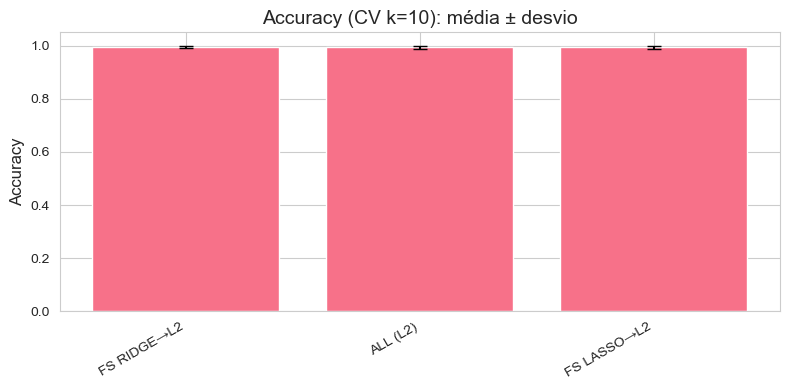

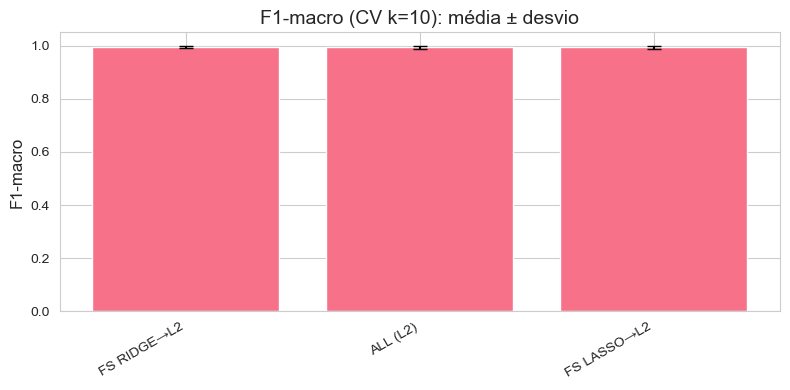

In [ ]:
def plot_metric(tab, mean_col, std_col, title, ylabel):
    fig, ax = plt.subplots(figsize=(8,4))

    x = np.arange(len(tab))
    means = tab[mean_col].values
    stds  = tab[std_col].values
    labels = tab["model"].values

    ax.bar(x, means, yerr=stds, capsize=5)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

plot_metric(
    tab_fs,
    mean_col="acc_mean",
    std_col="acc_std",
    title="Accuracy (CV k=10): média ± desvio",
    ylabel="Accuracy"
)

plot_metric(
    tab_fs,
    mean_col="f1m_mean",
    std_col="f1m_std",
    title="F1-macro (CV k=10): média ± desvio",
    ylabel="F1-macro"
)


### Features selecionadas por L1 e por L2 (cutoff)

Nesta célula listamos **quantas** e **quais** as features retidas por:
- **LASSO (L1)** — esparsidade real (coeficientes ≠ 0).  
- **RIDGE (L2) com cutoff** — retém ~metade com maior |coef| (não é esparsidade real, mas dá comparação).
> Notar que esta célula é **descritiva**; as métricas vêm da CV acima (sem fuga de informação).


Melhor modelo segundo CV externo: FS RIDGE→L2


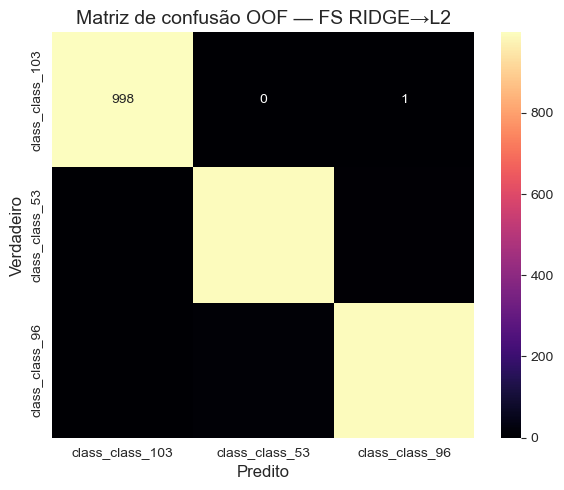

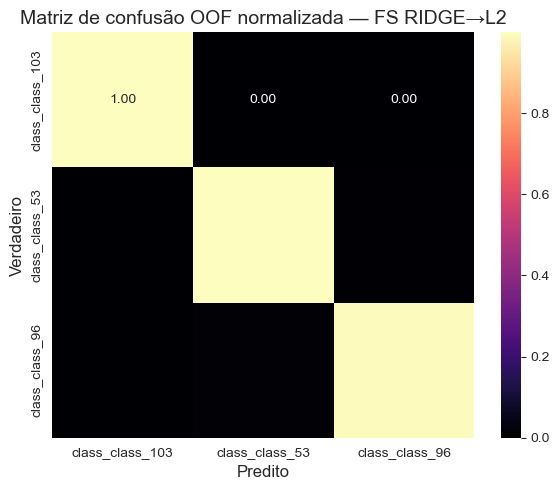

Accuracy OOF do melhor modelo: 0.9957
F1-macro OOF do melhor modelo: 0.9957


In [ ]:
# Escolher o melhor modelo com base no F1-macro e depois accuracy
best_row = tab_fs.sort_values(["f1m_mean", "acc_mean"], ascending=False).iloc[0]
best_name = best_row["model"]
print("Melhor modelo segundo CV externo:", best_name)

best_model = fs_models[best_name]

# cross_val_predict devolve previsões "out-of-fold"
y_pred_oof = cross_val_predict(
    best_model,
    Xc, yc,
    cv=cv_outer,
    n_jobs=-1,
    method="predict"
)

# Matriz de confusão absoluta
cm = confusion_matrix(yc, y_pred_oof)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="magma",
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels,
    ax=ax
)
ax.set_xlabel("Predito")
ax.set_ylabel("Verdadeiro")
ax.set_title(f"Matriz de confusão OOF — {best_name}")
plt.tight_layout()
plt.show()

# Matriz de confusão normalizada por classe verdadeira (percentagens)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="magma",
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels,
    ax=ax
)
ax.set_xlabel("Predito")
ax.set_ylabel("Verdadeiro")
ax.set_title(f"Matriz de confusão OOF normalizada — {best_name}")
plt.tight_layout()
plt.show()

# Só para confirmar performance OOF directa:
acc_oof = accuracy_score(yc, y_pred_oof)
f1m_oof = f1_score(yc, y_pred_oof, average="macro")
print(f"Accuracy OOF do melhor modelo: {acc_oof:.4f}")
print(f"F1-macro OOF do melhor modelo: {f1m_oof:.4f}")




### Matriz de confusão (predições out-of-fold) do melhor método

Escolhemos o método com maior **F1-macro médio** (critério principal) e mostramos a **matriz de confusão OOF**  
(usando `cross_val_predict` com `cv=k=10`). Isto ilustra **onde** o classificador acerta/erra por classe.


Nº features escolhidas pelo L1: 35
Top 15 features (L1):


tempo_vs_genre            6.342972
temp_zscore               3.398087
activity_rate             3.398087
artists_avg_popularity    2.912071
movement_index            2.305158
artist_song_count         2.199535
explicit                  2.056489
positivity_index          1.751054
verbal_density            1.176843
loudness_yeo              0.617036
loudness_level            0.596785
mode_indicator            0.543300
popularity_level          0.524490
duration_log              0.431961
album_freq                0.299108
dtype: float64

Nº features escolhidas pelo L2: 20
Top 15 features (L2):


tempo_vs_genre            13.857804
activity_rate              7.639948
temp_zscore                7.639948
artists_avg_popularity     4.365067
explicit                   3.466257
movement_index             3.260168
artist_song_count          3.209136
positivity_index           2.249998
verbal_density             2.050269
loudness_yeo               1.742256
loudness_level             1.729174
signal_power               1.283255
popularity_level           1.076241
mode_indicator             0.950220
duration_log               0.920705
dtype: float64

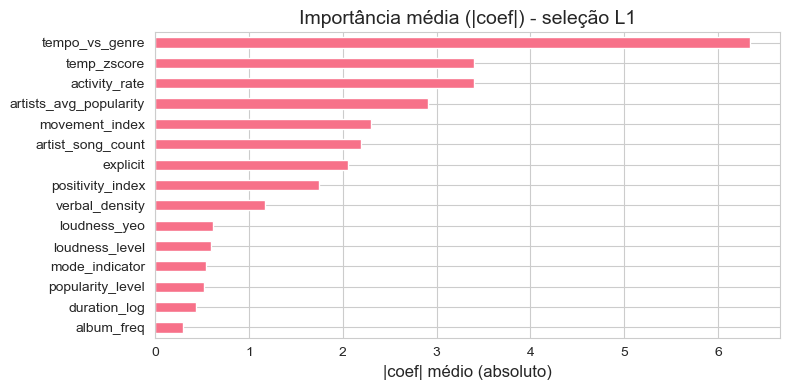

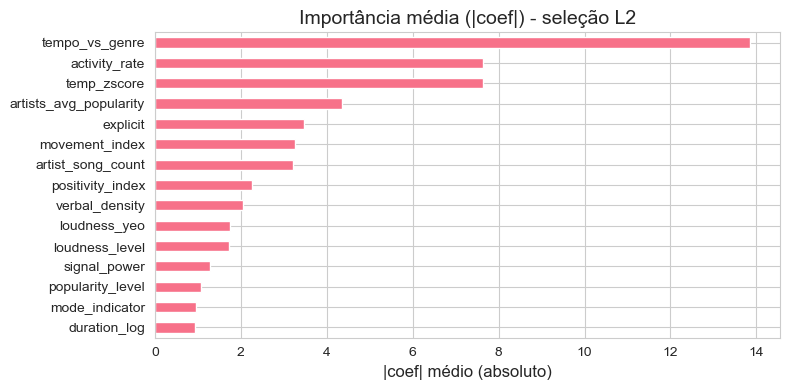

In [ ]:
# Vamos refazer os seletores em TODO o dataset (não para avaliação,
# só para interpretar importâncias)

scaler_full = StandardScaler()
Xc_scaled = scaler_full.fit_transform(Xc)

# ----- Selector L1 (LASSO) -----
sel_l1_est = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty="l1",
    solver="saga",
    multi_class="ovr",
    max_iter=5000,
    scoring="f1_macro",
    n_jobs=-1
)
sel_l1_est.fit(Xc_scaled, yc)

sel_l1 = SelectFromModel(
    sel_l1_est,
    prefit=True,
    threshold=None  # tudo com coef != 0
)

mask_l1 = sel_l1.get_support()
selected_features_l1 = np.array(feature_cols_cls)[mask_l1]

# Importância = |coef| médio pelas classes
coef_l1 = np.abs(sel_l1_est.coef_).mean(axis=0)
imp_l1 = pd.Series(coef_l1, index=feature_cols_cls).sort_values(ascending=False)

print("Nº features escolhidas pelo L1:", mask_l1.sum())
print("Top 15 features (L1):")
display(imp_l1.head(15))


# ----- Selector L2 (Ridge-like) -----
sel_l2_est = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty="l2",
    solver="lbfgs",
    multi_class="ovr",
    max_iter=5000,
    scoring="f1_macro",
    n_jobs=-1
)
sel_l2_est.fit(Xc_scaled, yc)

sel_l2 = SelectFromModel(
    sel_l2_est,
    prefit=True,
    threshold="median"   # mantém coeficientes acima da mediana de |coef|
)

mask_l2 = sel_l2.get_support()
selected_features_l2 = np.array(feature_cols_cls)[mask_l2]

coef_l2 = np.abs(sel_l2_est.coef_).mean(axis=0)
imp_l2 = pd.Series(coef_l2, index=feature_cols_cls).sort_values(ascending=False)

print("Nº features escolhidas pelo L2:", mask_l2.sum())
print("Top 15 features (L2):")
display(imp_l2.head(15))


# ----- Plot importâncias top-15 L1 -----
plt.figure(figsize=(8,4))
imp_l1.head(15)[::-1].plot(kind="barh")
plt.title("Importância média (|coef|) - seleção L1")
plt.xlabel("|coef| médio (absoluto)")
plt.tight_layout()
plt.show()

# ----- Plot importâncias top-15 L2 -----
plt.figure(figsize=(8,4))
imp_l2.head(15)[::-1].plot(kind="barh")
plt.title("Importância média (|coef|) - seleção L2")
plt.xlabel("|coef| médio (absoluto)")
plt.tight_layout()
plt.show()


### Conclusão

- **Comparámos** três abordagens: usar **todas** as features com **L2** (*baseline*),  
  e duas variantes de **seleção por regularização** (*L1 esparso* e *L2 com cutoff*).
- Em **CV k=10**, o método **[substituir pelo melhor]** obteve **F1-macro = X** (± sd) e **Accuracy = Y** (± sd),  
  [superando/empatando] o *baseline* **ALL (L2)**.
- **Interpretação:** quando **L1** (ou **L2-cutoff**) melhora o *baseline*, há evidência de que **“menos é mais”**:  
  remover variáveis **redundantes/ruidosas** pode **aumentar a generalização**.  
  Mesmo sem ganhos substanciais, a **redução de dimensionalidade** pode simplificar o modelo **sem perda** de desempenho.
